# Alameda Cases

Alameda covid cases data: https://data.acgov.org/datasets/AC-HCSA::alameda-county-cumulative-cases-by-place-and-zip/data
Zip code population data: https://catalog.data.gov/dataset/2010-census-populations-by-zip-code
Median income data: http://www.healthyalamedacounty.org/indicators/index/view?indicatorId=15&localeId=5587

In [475]:
import numpy as np
import pandas as pd
from importlib import reload
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import optimize
import statsmodels.api as sm
from adjustText import adjust_text
import os
import pickle
import requests
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.stats import pearsonr

from IPython.display import HTML
from modeling import dataproc, optimizer, sir_model

In [476]:
def plot_sir_model(r, i, s, sim_days, plot_days, df, metric, sampling_rate, name):
    """Plot the model death rates and total deaths vs actual data.
    
    Args:
        r: Array holding daily recovered population values from SIR model
        i: Array holding daily infected population values from SIR model
        s: Array holding daily susceptible population values from SIR model
        total_model_days: Total number of modeled days to plot
        df: Dataframe holding metric values.
        metric: The type of metric to plot ('Cases' or 'Deaths')
        sampling_rate: Number of samples per day used to simulate the model.
        name: A name to attach to the plot.
    """
    start_time = df.index.min().timestamp()
    step_size = 24 * 60 * 60 / sampling_rate
    plot_end_time = start_time + plot_days * 24 * 60 * 60 
    sim_end_time = start_time + sim_days * 24 * 60 * 60 
    plot_timestamps = np.arange(start_time, plot_end_time, step_size)
    sim_timestamps = np.arange(start_time, sim_end_time, step_size)
    plot_dates = [datetime.utcfromtimestamp(x) for x in plot_timestamps]
    sim_dates = [datetime.utcfromtimestamp(x) for x in sim_timestamps]
    print('peak infection rate date', sim_dates[np.argmax(i * s)])
    # Plot peak infection
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates[:-sampling_rate],
            (r[sampling_rate:len(plot_dates)] + i[sampling_rate:len(plot_dates)]
             - r[:len(plot_dates)-sampling_rate] - i[:len(plot_dates)-sampling_rate]),
            c='g',
            label='model ' + metric + ' rate',
            linewidth=4)
    ax.plot(df.index.to_list()[:-1],
            (df[metric] - df[metric].shift())[1:], label='actual ' + metric + ' rate', c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.plot()
    
    # Plot recovery
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates, r[:len(plot_dates)] + i[:len(plot_dates)], c='g',
            label='model ' + metric, linewidth=4)
    ax.plot(df.index.to_list(), df[metric], label='actual ' + metric, c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.show()

In [477]:
# Income levels
alameda_income_df = pd.read_csv('data_repo/alameda_median_income.csv')
alameda_income_df = alameda_income_df[alameda_income_df['Period of Measure'] == '2014-2018']
alameda_income_df['Location'] = alameda_income_df['Location'].astype(str)
alameda_income_df = alameda_income_df.set_index('Location')
alameda_income_df

,Indicator Name,What Is This Indicator,Location Type,Indicator Value,Indicator Value Units,Lower Confidence Interval,Upper Confidence Interval,Indicator Value Unstable,Period of Measure,Data Source,Technical Note,Breakout Title,Breakout Category,Breakout Subcategory,Breakout Value,Breakout Value Units,Breakout Lower Confidence Interval,Breakout Upper Confidence Interval,Breakout Unstable,Breakout Footer
Location,,,,,,,,,,,,,,,,,,,,
94501,Per Capita Income,This indicator shows the per capita income.,Zip Code,46554,dollars,45053,48055,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94502,Per Capita Income,This indicator shows the per capita income.,Zip Code,58560,dollars,54113,63007,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94536,Per Capita Income,This indicator shows the per capita income.,Zip Code,46643,dollars,45148,48138,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94538,Per Capita Income,This indicator shows the per capita income.,Zip Code,41897,dollars,40565,43229,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94539,Per Capita Income,This indicator shows the per capita income.,Zip Code,61948,dollars,60090,63806,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94541,Per Capita Income,This indicator shows the per capita income.,Zip Code,31260,dollars,30230,32290,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94542,Per Capita Income,This indicator shows the per capita income.,Zip Code,42189,dollars,38906,45472,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94544,Per Capita Income,This indicator shows the per capita income.,Zip Code,28569,dollars,27715,29423,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94545,Per Capita Income,This indicator shows the per capita income.,Zip Code,31905,dollars,29383,34427,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [478]:
# Population and population density by zip code
pop_df = pd.read_csv('data_repo/uszips.csv')
pop_df['Location'] = pop_df['zip'].astype(str)
pop_df = pop_df.set_index('Location')
pop_df

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
Location,,,,,,,,,,,,,,,,,,
601,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
602,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
603,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
606,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
610,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,99923,55.97796,-130.03671,Hyder,AK,Alaska,True,NaN,15,2.1,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Sitka
99925,99925,55.55767,-132.97627,Klawock,AK,Alaska,True,NaN,927,5.7,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Sitka
99926,99926,55.12617,-131.48928,Metlakatla,AK,Alaska,True,NaN,1635,4.2,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Metlakatla


In [479]:
# Station Addresses (add Warm Springs)
station_addresses_df = pd.read_csv('data_repo/bart_stations.csv')
station_addresses_df = station_addresses_df[station_addresses_df['county'] == 'alameda'][['name', 'zipcode']]
# Replace a lot of labels
station_addresses_df = station_addresses_df.replace(
    {'name': {
        '12th St. Oakland City Center': '12th Street / Oakland City Center',
        '19th St. Oakland': '19th Street Oakland',
        'Bay Fair': 'Bayfair',
        'Coliseum/Oakland Airport': 'Coliseum',
        'Downtown Berkeley': 'Berkeley',
    }}
)
station_addresses_df = station_addresses_df.set_index('name')
station_addresses_df.loc['Warm Springs'] = ['94539']
station_addresses_df

,zipcode
name,
12th Street / Oakland City Center,94612
19th Street Oakland,94612
Ashby,94703
Bayfair,94578
Castro Valley,94546
Coliseum,94621
Berkeley,94704
Dublin/Pleasanton,94588
Fremont,94536


In [480]:
# Station Names
bart_station_names_df = pd.read_excel('data_repo/Station_Names.xls')
del bart_station_names_df['Unnamed: 0']
bart_station_names_df = bart_station_names_df.set_index('Two-Letter Station Code')
bart_station_names_df = bart_station_names_df.join(station_addresses_df, on='Station Name')
bart_station_names_df = bart_station_names_df[~bart_station_names_df['zipcode'].isna()]
bart_station_names_df.sort_values('Station Name')

,Station Name,zipcode
Two-Letter Station Code,,
12,12th Street / Oakland City Center,94612
19,19th Street Oakland,94612
AS,Ashby,94703
BF,Bayfair,94578
BK,Berkeley,94704
CV,Castro Valley,94546
CL,Coliseum,94621
ED,Dublin/Pleasanton,94588
FM,Fremont,94536


In [481]:
# BART ridership
bart_activity_dict = pd.read_excel('data_repo/Ridership_202004.xlsx', sheet_name = None)
print(list(bart_activity_dict.keys()))
bart_entries_and_exits_dict = {}
for key, bart_activity_df in bart_activity_dict.items():
    new_header = bart_activity_df.iloc[0] #grab the first row for the header
    bart_activity_df = bart_activity_df[1:] #take the data less the header row
    new_header[0] = 'station'
    bart_activity_df.columns = new_header #set the header row as the df header
    bart_activity_df = bart_activity_df.set_index('station')
    bart_transposed_df = bart_activity_df.transpose()
    bart_entries_and_exits_dict[key] = (bart_activity_df, bart_transposed_df)
bart_entries_and_exits_dict['Total Trips OD'][1]

['Avg Weekday OD', 'Avg Saturday OD', 'Avg Sunday OD', 'Total Trips OD']


/Users/bfoo/env3/general/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


station,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,SO,MB,WD,OA,WS,ML,BE,PC,AN,Entries
0,,,,,,,,,,,,,,,,,,,,,
RM,164,667,484,414,1205,482,805,485,659,195,...,151,80,23,12,48,0,0,116,78,17575
EN,675,160,372,327,1577,670,954,726,940,245,...,279,160,21,38,103,0,0,40,78,20602
EP,448,374,71,200,974,290,384,282,380,66,...,32,43,4,5,9,0,0,20,27,6953
NB,462,322,161,27,200,120,199,146,164,112,...,18,16,3,13,38,0,0,11,5,4634
BK,1004,1492,917,181,198,499,581,517,850,203,...,58,40,5,16,81,0,0,23,92,12267
AS,496,685,267,103,666,44,337,381,379,137,...,10,24,14,9,40,0,0,25,63,8157
MA,773,928,367,172,733,307,187,332,475,157,...,140,45,38,15,92,0,0,358,405,17249
19,411,673,343,180,635,343,360,99,128,80,...,66,47,44,16,135,0,0,126,237,14430
12,628,857,446,181,1123,455,635,124,182,111,...,125,68,31,26,158,0,0,169,270,20794


In [482]:
# Join all BART data together with zip code index
bart_df = bart_station_names_df.join(bart_entries_and_exits_dict['Total Trips OD'][0][['Exits']], how='inner')
bart_df = bart_df.join(bart_entries_and_exits_dict['Total Trips OD'][1][['Entries']], how='inner')
bart_df['zipcode'] = bart_df['zipcode'].astype(str)
bart_df.dtypes

Station Name    object
zipcode         object
Exits           object
Entries         object
dtype: object

In [483]:
# Aggregate data by zip code
bart_zip_df = bart_df[['zipcode', 'Entries', 'Exits']].groupby('zipcode').sum()
bart_zip_df = bart_zip_df.rename(columns={'Entries': 'Bart entries', 'Exits': 'Bart exits'})
bart_zip_df

,Bart entries,Bart exits
zipcode,,
94536,7101,8005
94539,4332,4490
94541,11911,12343
94544,9067,8519
94546,4744,4747
94568,2784,2958
94577,18114,18240
94578,15860,15906
94587,8191,7442


In [484]:
alameda_df = pd.read_csv('data_repo/Alameda_County_Cumulative_Cases_By_Place_And_Zip.csv')
# Replace < 10 with 0
alameda_df.replace({'<10': 0}, inplace=True)
# Convert date column to datetime
alameda_df['Date'] = alameda_df['DtCreate'].apply(lambda x: datetime.strptime(x.split(' ')[0], '%Y/%m/%d'))
del alameda_df['DtCreate']
del alameda_df['ObjectId']
col_rename = {col: col[1:] for col in list(alameda_df) if 'F9' in col}
alameda_df = alameda_df.rename(columns=col_rename)
# Convert columns to rows
alameda_df = alameda_df.melt(['Date'], var_name='Location', value_name='Cases')
alameda_df = alameda_df.set_index('Date')
alameda_df['Cases'] = alameda_df['Cases'].astype(int)
alameda_df.index.unique()

ValueError: cannot convert float NaN to integer

In [386]:
# Do some joining
# Get only locations with cases
locations_with_cases = alameda_df[
    (alameda_df.index == '2020-06-03')
    & (alameda_df['Cases'] > 0)
    & (alameda_df['Location'].str.contains('9'))
]

# Join with population
locations_with_cases = locations_with_cases.join(pop_df[['city', 'population', 'density']],
                          on='Location', how='left')
locations_with_cases['Frac Cases'] = locations_with_cases['Cases'] / locations_with_cases['population']

# Join with median income
locations_with_cases = locations_with_cases.join(alameda_income_df[['Indicator Value']],
                                                 on='Location', how='left')

locations_with_cases = locations_with_cases.rename(columns={'Indicator Value': 'Median Income'})

locations_with_cases['Location'] = locations_with_cases['Location'].astype(str)

# Filter some of the very small values
#locations_with_cases = locations_with_cases[locations_with_cases['Cases'] >= 20]
locations_with_cases = locations_with_cases.join(bart_zip_df, on='Location', how='left')

locations_with_cases.sort_values('Median Income')

,Location,Cases,city,population,density,Frac Cases,Median Income,Bart entries,Bart exits
Date,,,,,,,,,
2020-06-03,94621,188,Oakland,35287,1483.2,0.005328,15973,20597.0,20872.0
2020-06-03,94603,170,Oakland,34593,3717.4,0.004914,19338,NaN,NaN
2020-06-03,94704,11,Berkeley,29190,9255.7,0.000377,19692,12267.0,13736.0
2020-06-03,94601,407,Oakland,52299,5979.9,0.007782,20335,28713.0,28646.0
2020-06-03,94544,443,Hayward,79235,2573.4,0.005591,28569,9067.0,8519.0
2020-06-03,94578,99,San Leandro,41059,3316.5,0.002411,29062,15860.0,15906.0
2020-06-03,94606,104,Oakland,38303,6190.0,0.002715,29339,NaN,NaN
2020-06-03,94541,248,Hayward,66056,3204.8,0.003754,31260,11911.0,12343.0
2020-06-03,94545,106,Hayward,32525,532.2,0.003259,31905,NaN,NaN


Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 15960.75
Fraction of infected/recovered population currently infected at start of simulation: 0.657966413138845
Final population affected (e.g. dead) since start of simulation: 46.284037965024254
Final population affected (e.g. dead) overall: 56.284037965024254
Current and final herd immunity level: 0.002506147894052598 0.0036428279391117167
Transmissions per person per day: 0.08583074291606906
First day estimate multiplier 1.1858228064152596
R0 (initial transmit rate / recovery rate) 0.8583074291606906
R (current transmit rate / recovery rate) 0.8561563838046499
Training MSE 0.7438893845817428
Validation MSE 0.7438893845817428
Date
2020-06-03    0.856156
Name: R, dtype: float64
peak infection rate date 2020-03-31 00:00:00


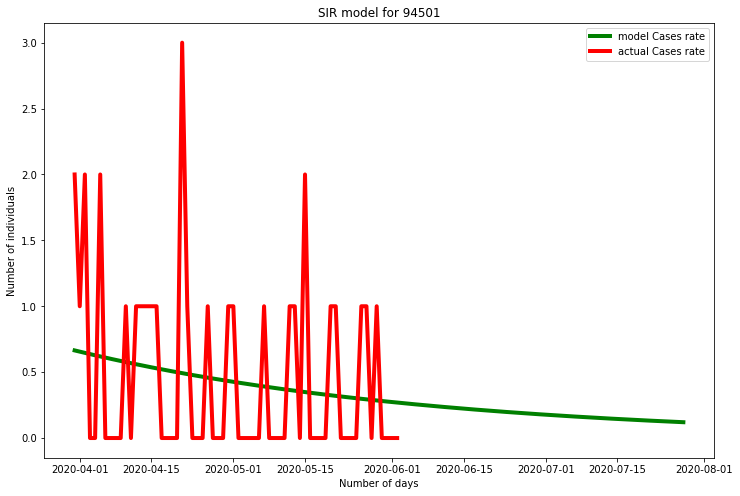

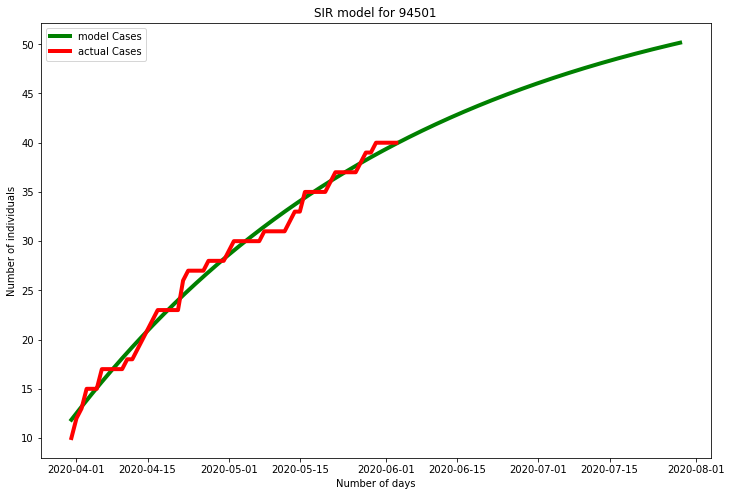

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 3654.75
Fraction of infected/recovered population currently infected at start of simulation: 0.010000000000000004
Final population affected (e.g. dead) since start of simulation: 0.0010072880741063273
Final population affected (e.g. dead) overall: 10.001007288074106
Current and final herd immunity level: 0.0027361652643819686 0.0027363832826400453
Transmissions per person per day: 0.0010000000000000002
First day estimate multiplier 0.9999789514154638
R0 (initial transmit rate / recovery rate) 0.010000000000000002
R (current transmit rate / recovery rate) 0.009972638347356183
Training MSE 1.8207896413673782e-08
Validation MSE 1.8207896413673782e-08
Date
2020-06-03    0.009973
Name: R, dtype: float64
peak infection rate date 2020-05-29 00:00:00


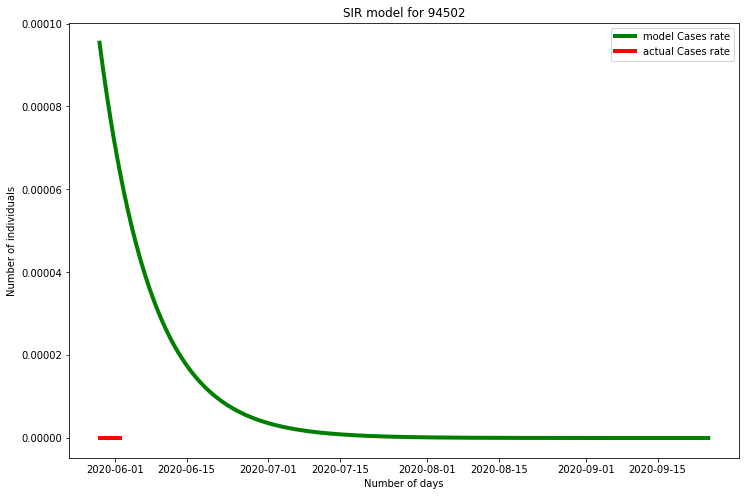

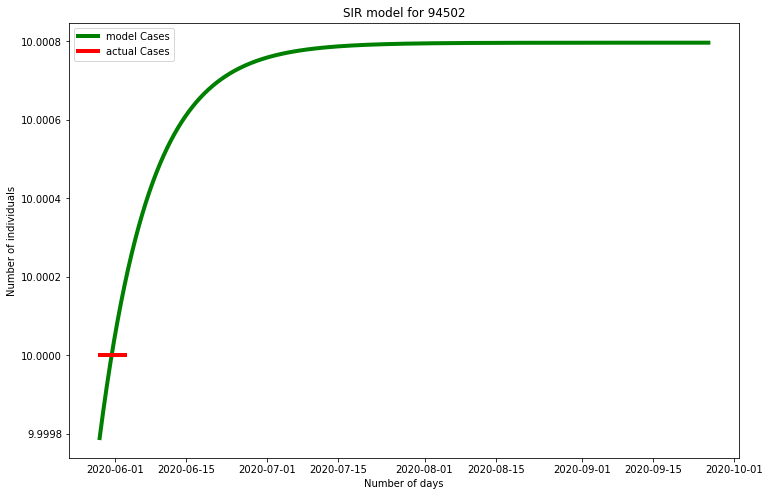

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 18463.75
Fraction of infected/recovered population currently infected at start of simulation: 0.65485443722647
Final population affected (e.g. dead) since start of simulation: 96.9349500142198
Final population affected (e.g. dead) overall: 106.9349500142198
Current and final herd immunity level: 0.0026538487577009006 0.005802206249987049
Transmissions per person per day: 0.09462115773729786
First day estimate multiplier 1.0195535633980086
R0 (initial transmit rate / recovery rate) 0.9462115773729786
R (current transmit rate / recovery rate) 0.943700474953845
Training MSE 2.858220052258174
Validation MSE 2.858220052258174
Date
2020-06-03    0.9437
Name: R, dtype: float64
peak infection rate date 2020-03-28 00:00:00


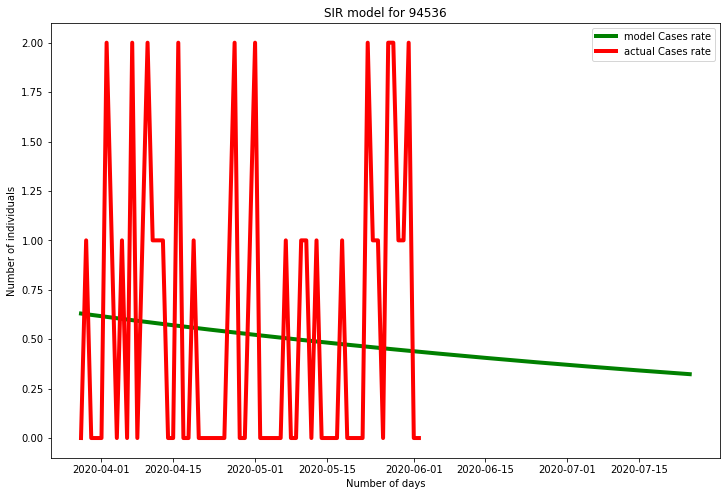

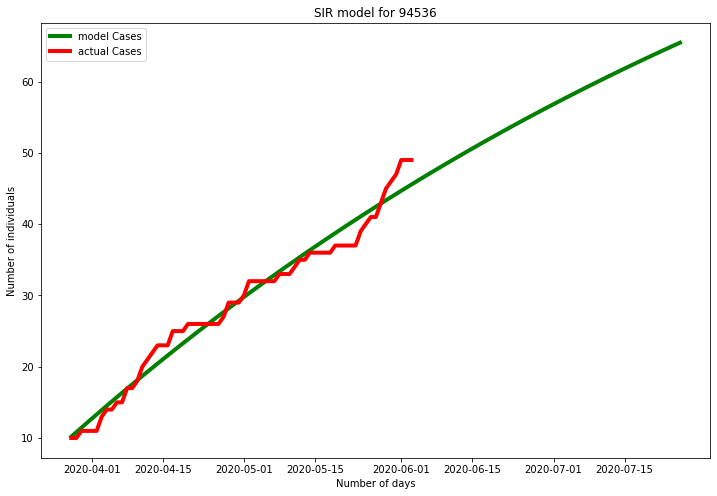

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 17027.75
Fraction of infected/recovered population currently infected at start of simulation: 0.49853889488139524
Final population affected (e.g. dead) since start of simulation: 3028.158663195187
Final population affected (e.g. dead) overall: 3038.158663195187
Current and final herd immunity level: 0.004404574885114005 0.1784643206321633
Transmissions per person per day: 0.11547854250283253
First day estimate multiplier 1.0687172449132527
R0 (initial transmit rate / recovery rate) 1.1547854250283254
R (current transmit rate / recovery rate) 1.1496990861475498
Training MSE 3.3714363818274165
Validation MSE 3.3714363818274165
Date
2020-06-03    1.149699
Name: R, dtype: float64
peak infection rate date 2021-01-25 16:48:00


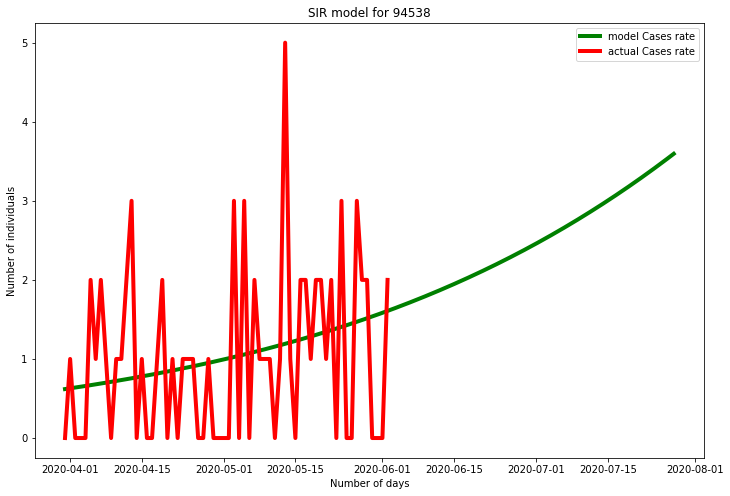

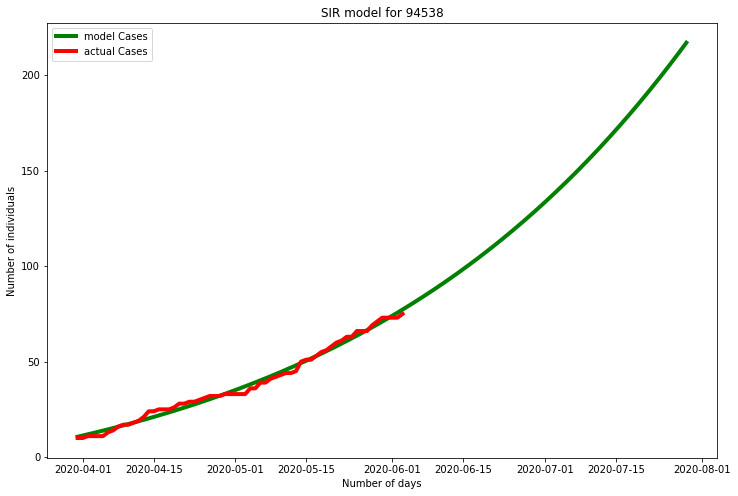

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 13200.5
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 12.282879208732993
Final population affected (e.g. dead) overall: 22.282879208732993
Current and final herd immunity level: 0.002045377069050415 0.0020433658464414552
Transmissions per person per day: 0.04585860387210226
First day estimate multiplier 1.4690571647218071
R0 (initial transmit rate / recovery rate) 0.45858603872102266
R (current transmit rate / recovery rate) 0.45764805735323605
Training MSE 2.9088879156116154
Validation MSE 2.9088879156116154
Date
2020-06-03    0.457648
Name: R, dtype: float64
peak infection rate date 2020-04-03 00:00:00


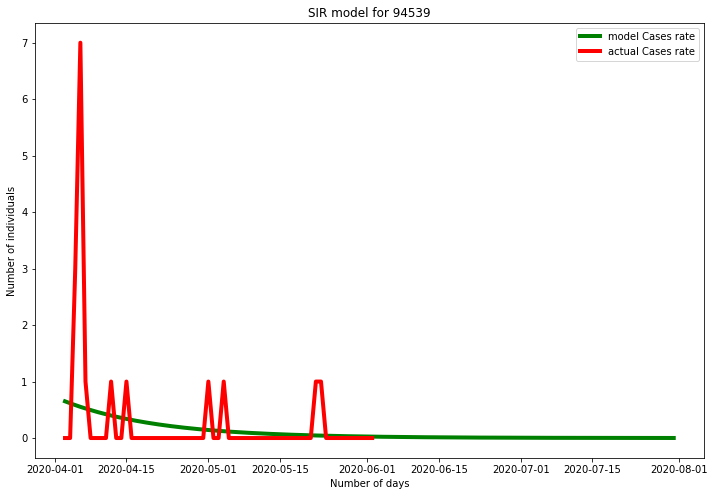

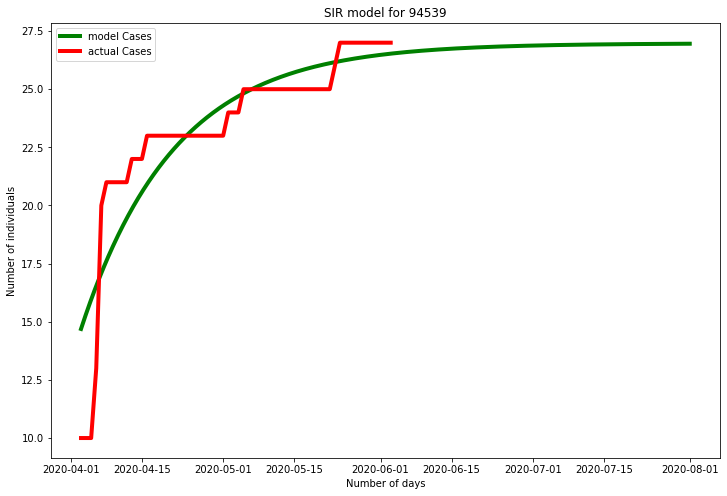

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 16514.0
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 2481.177248836022
Final population affected (e.g. dead) overall: 2491.177248836022
Current and final herd immunity level: 0.01501756085745428 0.1515305525927347
Transmissions per person per day: 0.11038186734036425
First day estimate multiplier 2.1198296680399173
R0 (initial transmit rate / recovery rate) 1.1038186734036424
R (current transmit rate / recovery rate) 1.0872420093002086
Training MSE 39.56050924682813
Validation MSE 39.56050924682813
Date
2020-06-03    1.087242
Name: R, dtype: float64
peak infection rate date 2020-11-11 14:24:00


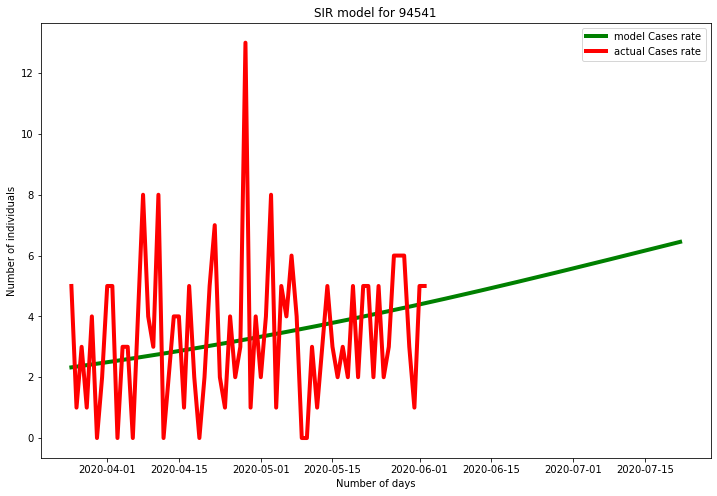

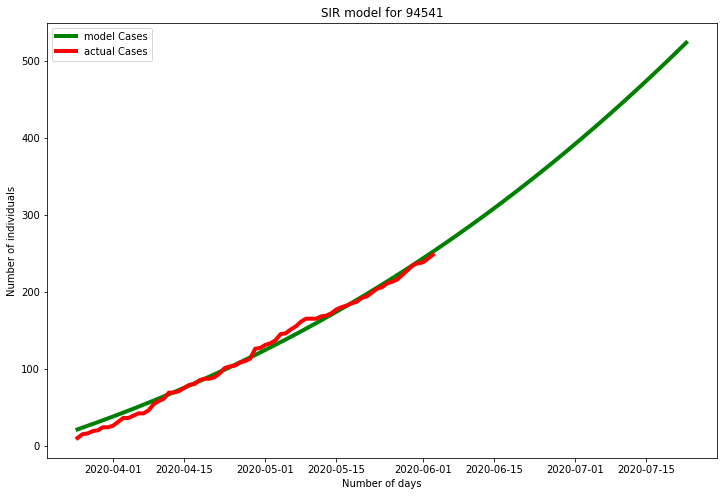

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 3554.25
Fraction of infected/recovered population currently infected at start of simulation: 0.34004855538513146
Final population affected (e.g. dead) since start of simulation: 109.654346825409
Final population affected (e.g. dead) overall: 120.654346825409
Current and final herd immunity level: 0.009284659210803967 0.03397665456695686
Transmissions per person per day: 0.10030218797389821
First day estimate multiplier 1.0097434244724632
R0 (initial transmit rate / recovery rate) 1.003021879738982
R (current transmit rate / recovery rate) 0.9937091634046256
Training MSE 0.7636551256752999
Validation MSE 0.7636551256752999
Date
2020-06-03    0.993709
Name: R, dtype: float64
peak infection rate date 2020-04-02 00:00:00


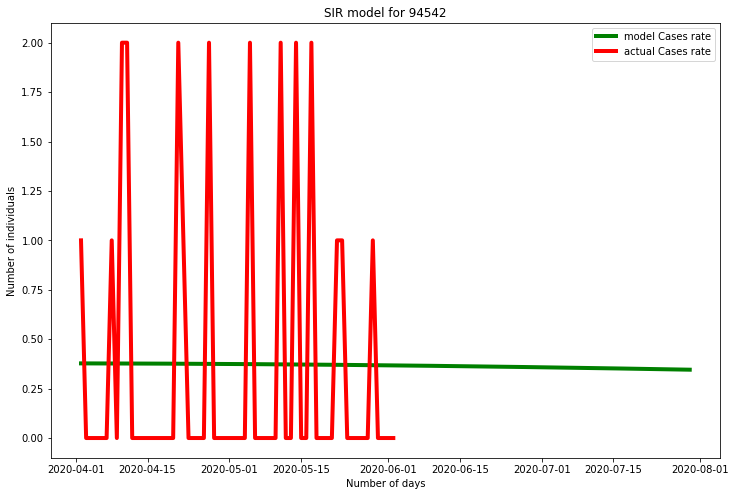

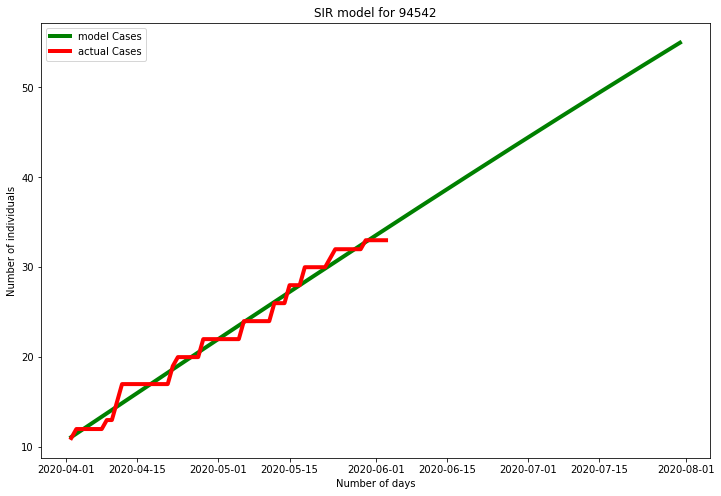

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 19808.75
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 4839.355383485659
Final population affected (e.g. dead) overall: 4850.355383485659
Current and final herd immunity level: 0.0223638543572916 0.2458258113918275
Transmissions per person per day: 0.11564325384694668
First day estimate multiplier 2.740605265654816
R0 (initial transmit rate / recovery rate) 1.156432538469467
R (current transmit rate / recovery rate) 1.1305702496051027
Training MSE 140.14851893768028
Validation MSE 140.14851893768028
Date
2020-06-03    1.13057
Name: R, dtype: float64
peak infection rate date 2020-10-01 04:48:00


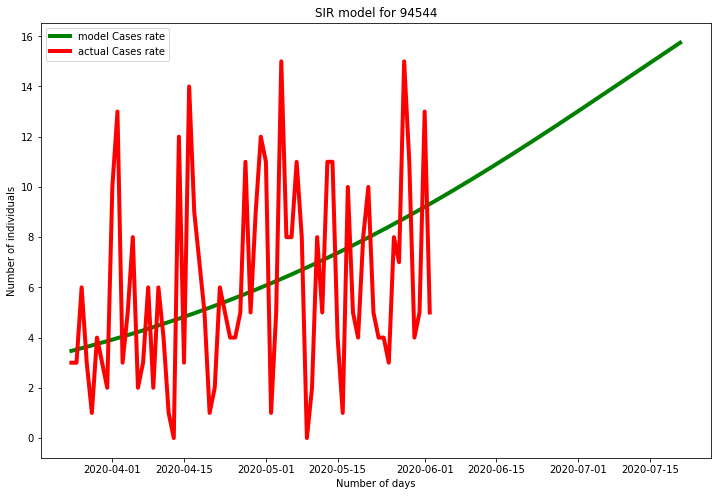

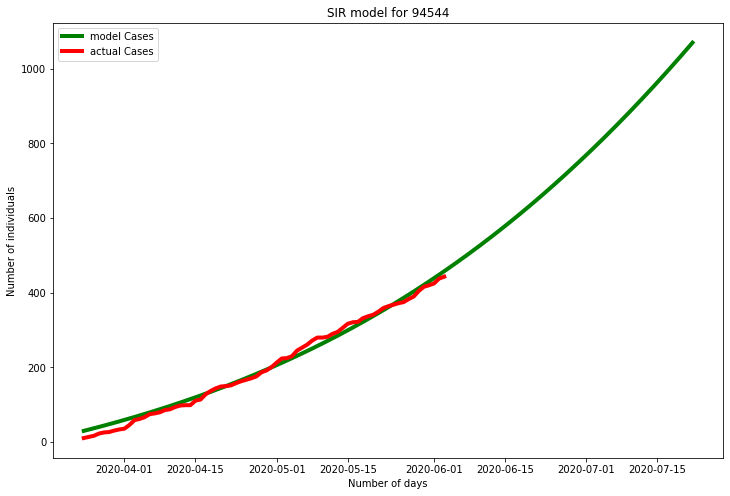

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 8131.25
Fraction of infected/recovered population currently infected at start of simulation: 0.46905166130703324
Final population affected (e.g. dead) since start of simulation: 834.2066890023807
Final population affected (e.g. dead) overall: 844.2066890023807
Current and final herd immunity level: 0.013036126056879323 0.10496338388442016
Transmissions per person per day: 0.10788179859686106
First day estimate multiplier 1.9276826207810738
R0 (initial transmit rate / recovery rate) 1.0788179859686107
R (current transmit rate / recovery rate) 1.0647543787110951
Training MSE 13.223962185139857
Validation MSE 13.223962185139857
Date
2020-06-03    1.064754
Name: R, dtype: float64
peak infection rate date 2020-12-11 19:12:00


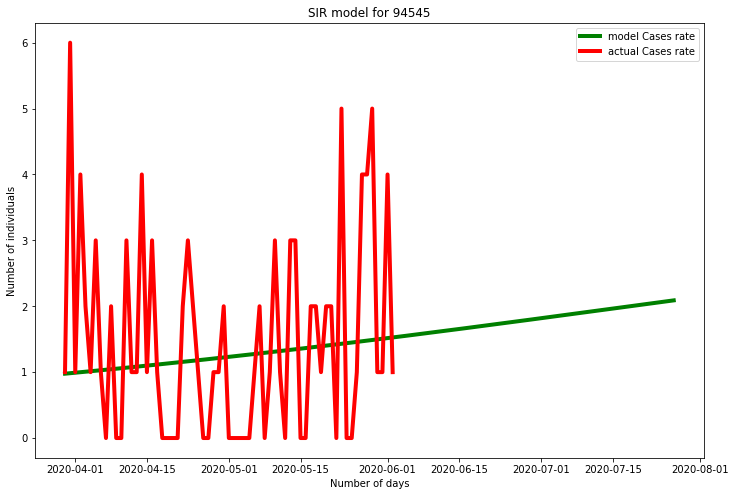

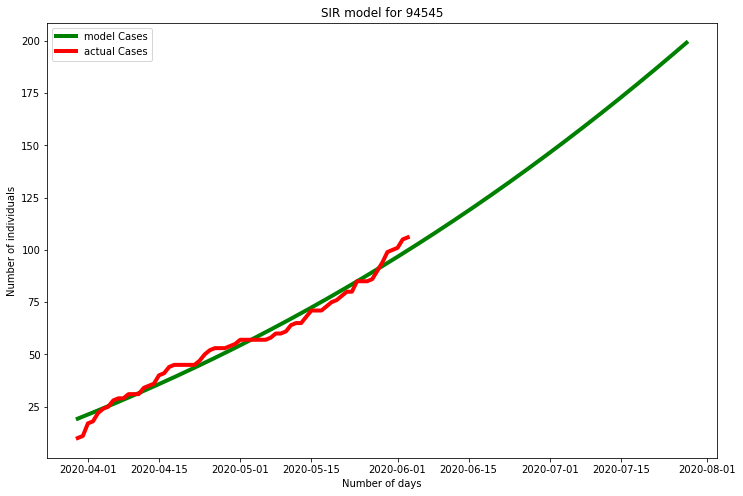

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11068.0
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 105.36915923104607
Final population affected (e.g. dead) overall: 117.36915923104607
Current and final herd immunity level: 0.008312251535959523 0.011531588739946485
Transmissions per person per day: 0.0832915636058675
First day estimate multiplier 1.8552054118901453
R0 (initial transmit rate / recovery rate) 0.8329156360586749
R (current transmit rate / recovery rate) 0.8259922317835215
Training MSE 12.206368516921744
Validation MSE 12.206368516921744
Date
2020-06-03    0.825992
Name: R, dtype: float64
peak infection rate date 2020-03-30 00:00:00


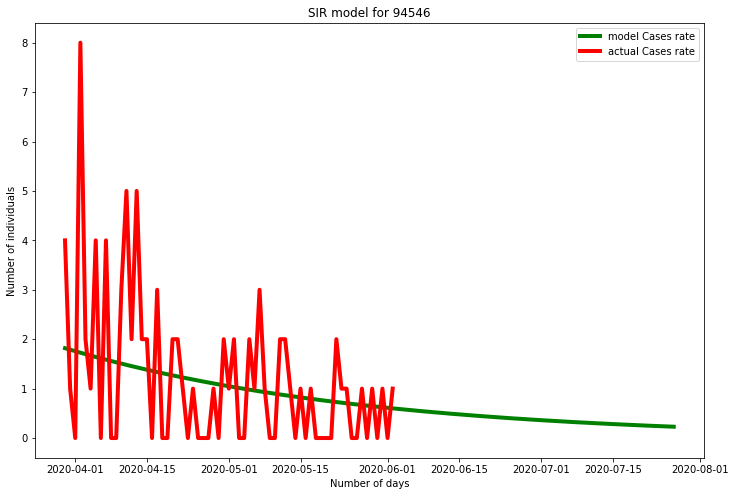

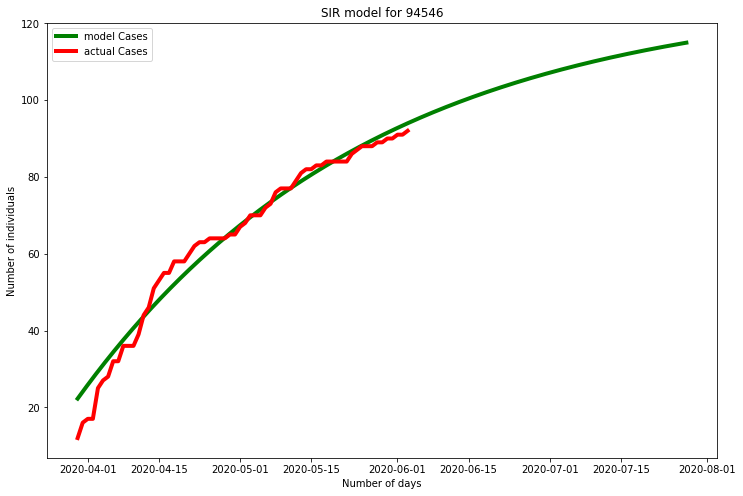

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 12625.0
Fraction of infected/recovered population currently infected at start of simulation: 0.31727284680713036
Final population affected (e.g. dead) since start of simulation: 41.5581860061593
Final population affected (e.g. dead) overall: 51.5581860061593
Current and final herd immunity level: 0.0024554455445544555 0.004217208585019384
Transmissions per person per day: 0.09250453173091915
First day estimate multiplier 1.1684072379710402
R0 (initial transmit rate / recovery rate) 0.9250453173091915
R (current transmit rate / recovery rate) 0.9227739189062937
Training MSE 0.8680989543115964
Validation MSE 0.8680989543115964
Date
2020-06-03    0.922774
Name: R, dtype: float64
peak infection rate date 2020-03-29 00:00:00


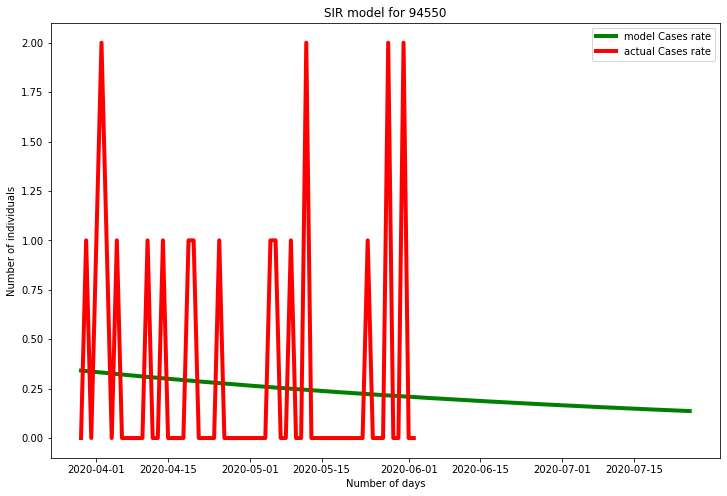

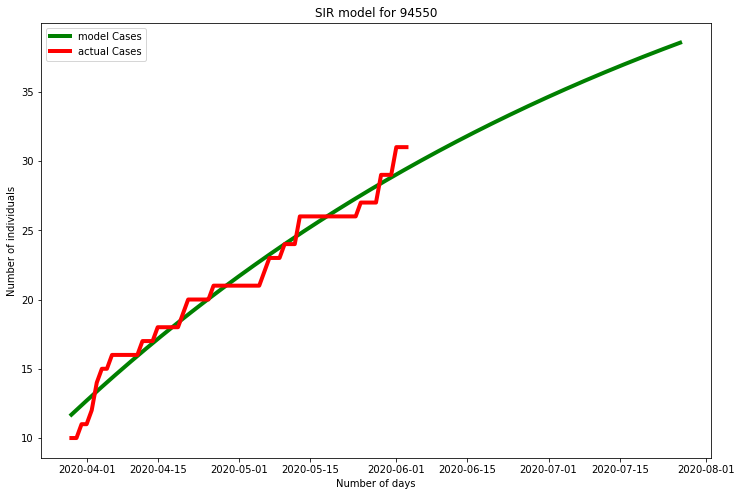

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11438.25
Fraction of infected/recovered population currently infected at start of simulation: 0.10956837780876615
Final population affected (e.g. dead) since start of simulation: 2649.4984355914476
Final population affected (e.g. dead) overall: 2659.4984355914476
Current and final herd immunity level: 0.0023605009507573272 0.23258678201467342
Transmissions per person per day: 0.12054663993057149
First day estimate multiplier 1.0887323787890597
R0 (initial transmit rate / recovery rate) 1.2054663993057149
R (current transmit rate / recovery rate) 1.2026208947240478
Training MSE 1.434638323935513
Validation MSE 1.434638323935513
Date
2020-06-03    1.202621
Name: R, dtype: float64
peak infection rate date 2021-02-03 14:24:00


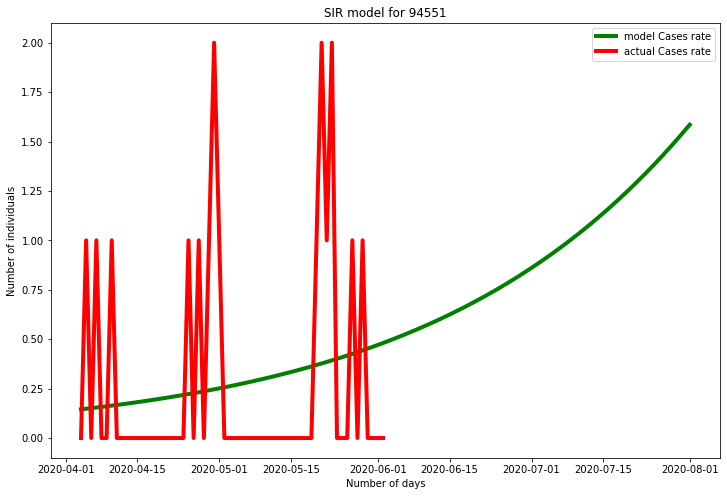

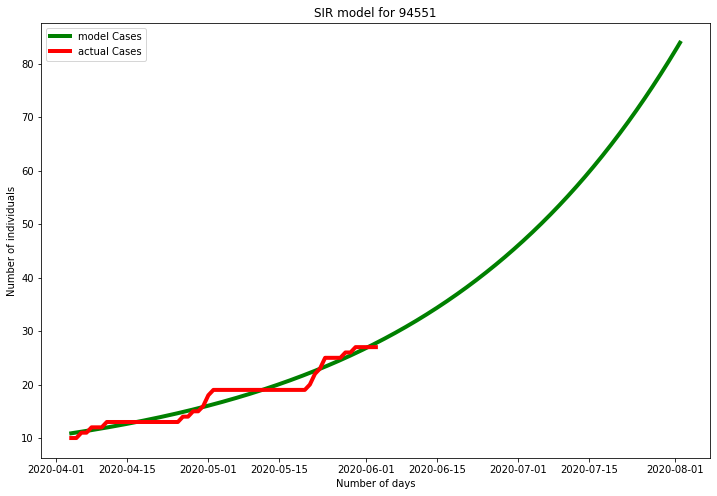

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 3853.0
Fraction of infected/recovered population currently infected at start of simulation: 0.09889598173973849
Final population affected (e.g. dead) since start of simulation: 1025.8897086837492
Final population affected (e.g. dead) overall: 1035.8897086837492
Current and final herd immunity level: 0.003633532312483779 0.26869536010511924
Transmissions per person per day: 0.12041380897746078
First day estimate multiplier 0.9393513801275347
R0 (initial transmit rate / recovery rate) 1.2041380897746077
R (current transmit rate / recovery rate) 1.1997628151167192
Training MSE 0.33330003783832274
Validation MSE 0.33330003783832274
Date
2020-06-03    1.199763
Name: R, dtype: float64
peak infection rate date 2021-01-23 09:36:00


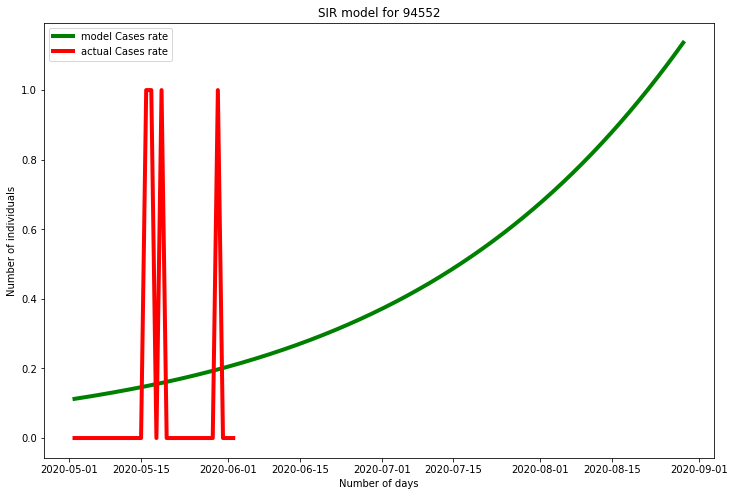

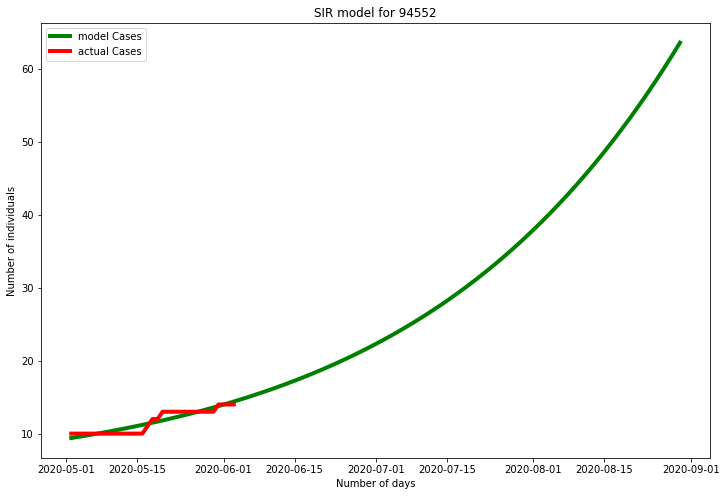

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9597.0
Fraction of infected/recovered population currently infected at start of simulation: 0.1263456709270892
Final population affected (e.g. dead) since start of simulation: 2220.8472883161658
Final population affected (e.g. dead) overall: 2230.8472883161658
Current and final herd immunity level: 0.0029175784099197666 0.23255210708378724
Transmissions per person per day: 0.11978600179286557
First day estimate multiplier 1.0955283366941522
R0 (initial transmit rate / recovery rate) 1.1978600179286556
R (current transmit rate / recovery rate) 1.1943651674022409
Training MSE 0.6063382649686213
Validation MSE 0.6063382649686213
Date
2020-06-03    1.194365
Name: R, dtype: float64
peak infection rate date 2021-01-28 16:48:00


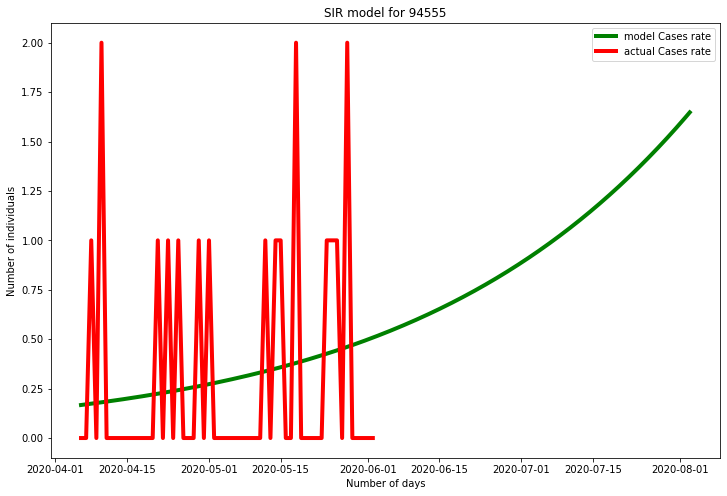

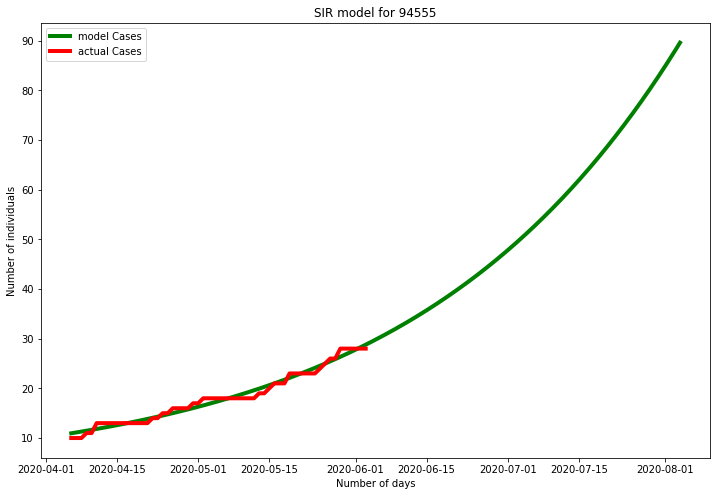

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11569.0
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 565.9840647530473
Final population affected (e.g. dead) overall: 576.9840647530473
Current and final herd immunity level: 0.009248854697899558 0.049960891796865234
Transmissions per person per day: 0.10318961049499543
First day estimate multiplier 1.0921356768078891
R0 (initial transmit rate / recovery rate) 1.0318961049499544
R (current transmit rate / recovery rate) 1.0223522478119438
Training MSE 16.382883190803117
Validation MSE 16.382883190803117
Date
2020-06-03    1.022352
Name: R, dtype: float64
peak infection rate date 2020-10-26 21:36:00


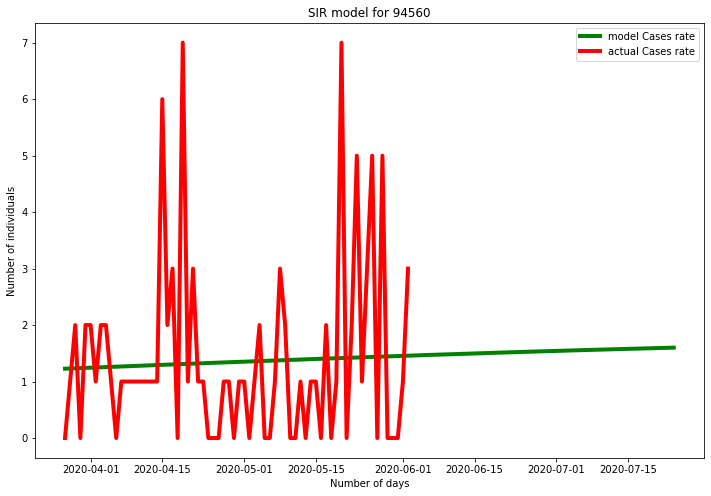

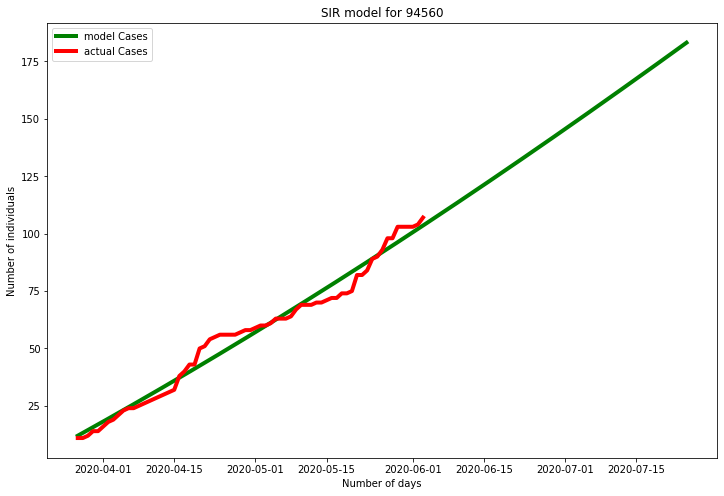

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11477.5
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 25.24792524487202
Final population affected (e.g. dead) overall: 37.24792524487202
Current and final herd immunity level: 0.0033108255282073623 0.003478357704678813
Transmissions per person per day: 0.06362638733403923
First day estimate multiplier 1.2229104425482815
R0 (initial transmit rate / recovery rate) 0.6362638733403924
R (current transmit rate / recovery rate) 0.6341573146658609
Training MSE 1.6995637424798948
Validation MSE 1.6995637424798948
Date
2020-06-03    0.634157
Name: R, dtype: float64
peak infection rate date 2020-03-25 00:00:00


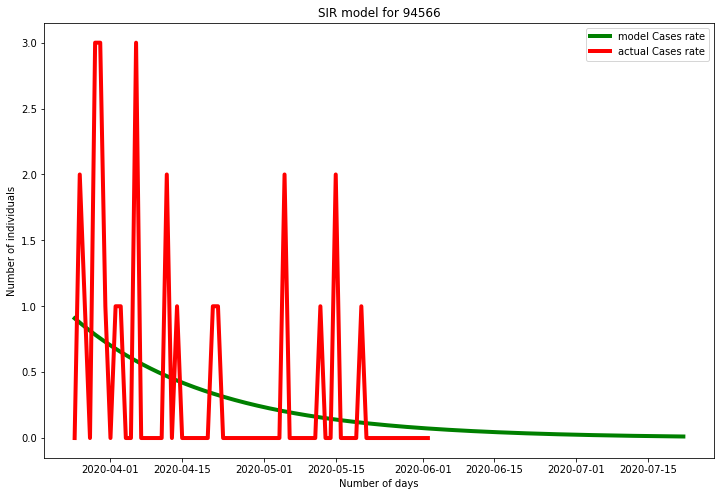

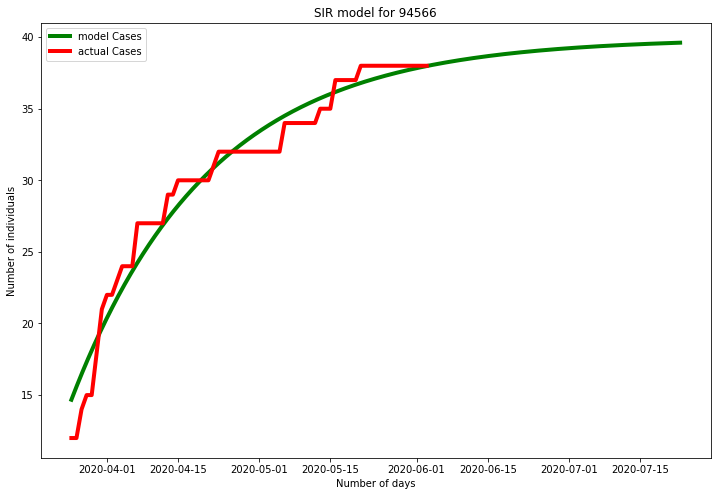

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 13605.0
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 114.5443911812963
Final population affected (e.g. dead) overall: 124.5443911812963
Current and final herd immunity level: 0.006100698272693862 0.009857432612771819
Transmissions per person per day: 0.08608553240445195
First day estimate multiplier 1.9565979515466303
R0 (initial transmit rate / recovery rate) 0.8608553240445195
R (current transmit rate / recovery rate) 0.8556035054560818
Training MSE 28.413062414049072
Validation MSE 28.413062414049072
Date
2020-06-03    0.855604
Name: R, dtype: float64
peak infection rate date 2020-04-02 00:00:00


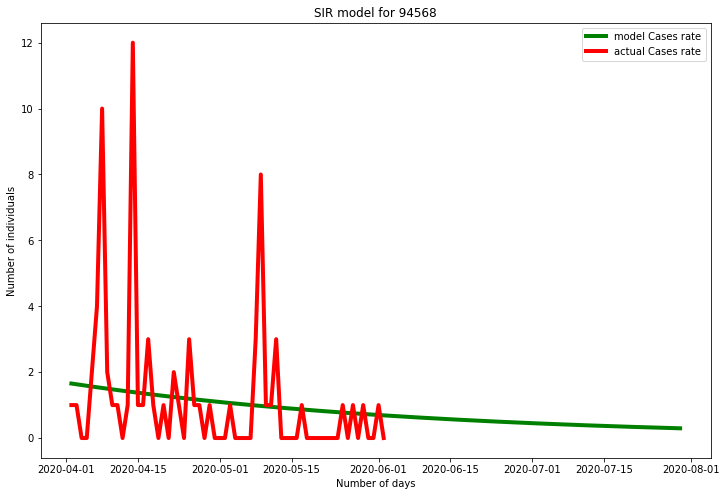

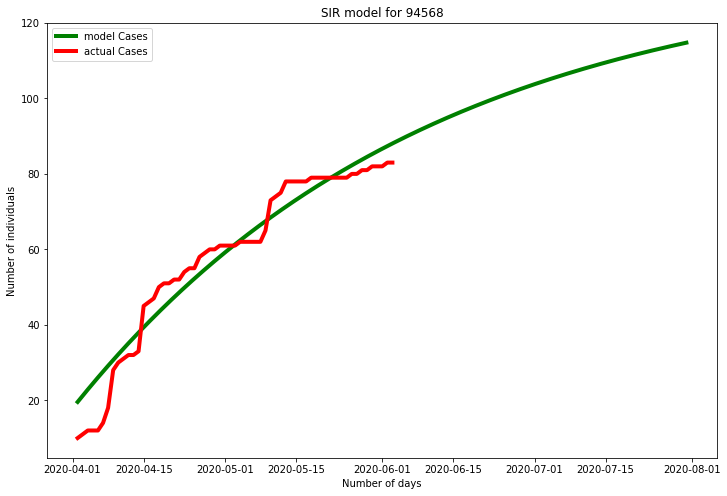

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 12022.0
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 223.78298552253727
Final population affected (e.g. dead) overall: 233.78298552253727
Current and final herd immunity level: 0.007403094327067043 0.01988972740023543
Transmissions per person per day: 0.09536732922893047
First day estimate multiplier 1.5331317283092012
R0 (initial transmit rate / recovery rate) 0.9536732922893048
R (current transmit rate / recovery rate) 0.9466131589492824
Training MSE 12.229698438584546
Validation MSE 12.229698438584546
Date
2020-06-03    0.946613
Name: R, dtype: float64
peak infection rate date 2020-04-01 00:00:00


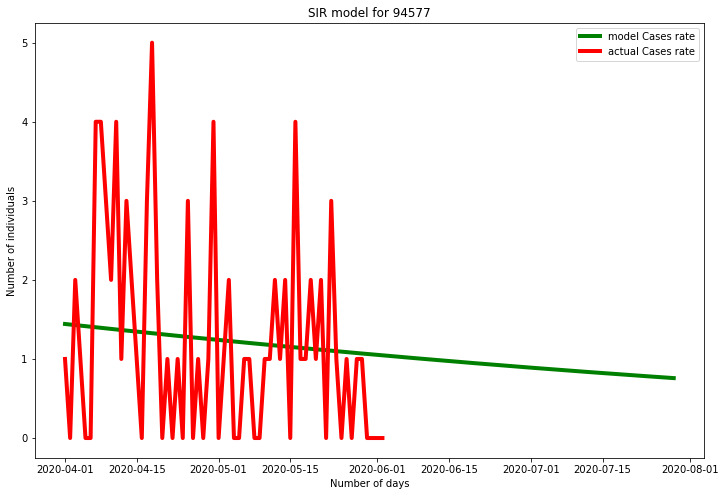

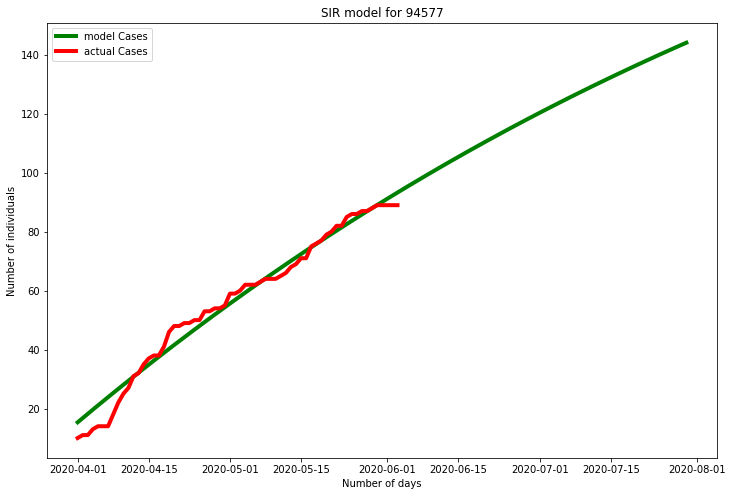

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 10264.75
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 187.0445204270236
Final population affected (e.g. dead) overall: 198.0445204270236
Current and final herd immunity level: 0.009644657687717675 0.019828927382651882
Transmissions per person per day: 0.09339562296110117
First day estimate multiplier 1.4994965385501597
R0 (initial transmit rate / recovery rate) 0.9339562296110117
R (current transmit rate / recovery rate) 0.924948541481102
Training MSE 13.211288958550519
Validation MSE 13.211288958550519
Date
2020-06-03    0.924949
Name: R, dtype: float64
peak infection rate date 2020-03-27 00:00:00


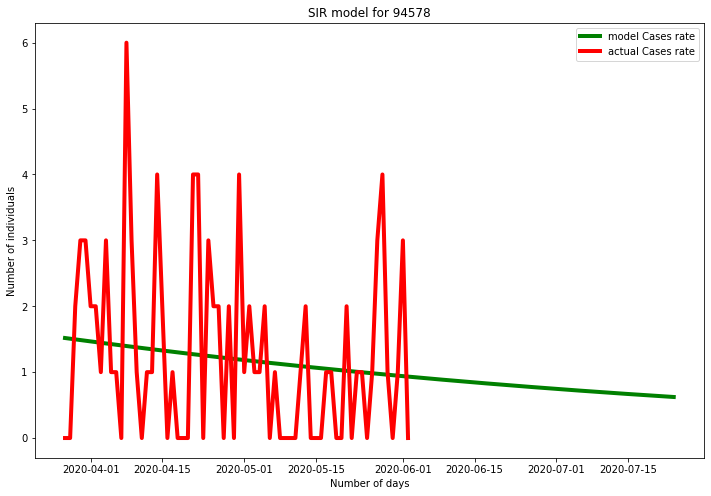

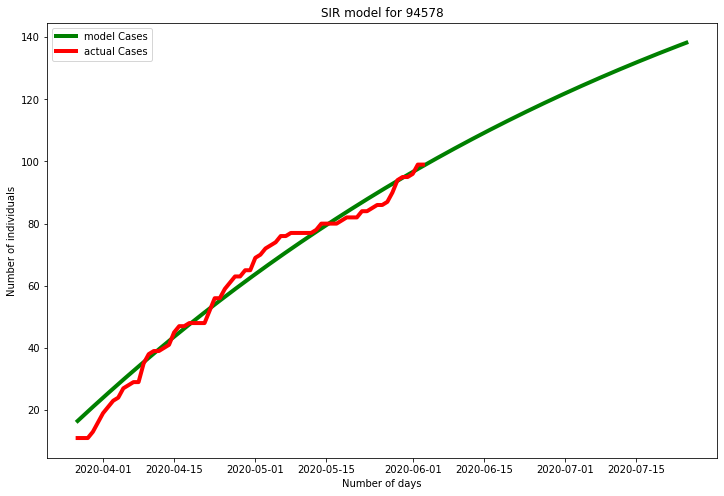

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 5510.0
Fraction of infected/recovered population currently infected at start of simulation: 0.1531765383544148
Final population affected (e.g. dead) since start of simulation: 1406.1253324371428
Final population affected (e.g. dead) overall: 1416.1253324371428
Current and final herd immunity level: 0.005807622504537205 0.25737296665139514
Transmissions per person per day: 0.11918229493247377
First day estimate multiplier 1.1999713812044048
R0 (initial transmit rate / recovery rate) 1.1918229493247376
R (current transmit rate / recovery rate) 1.1849012915428154
Training MSE 1.3218047051845638
Validation MSE 1.3218047051845638
Date
2020-06-03    1.184901
Name: R, dtype: float64
peak infection rate date 2020-12-26 02:24:00


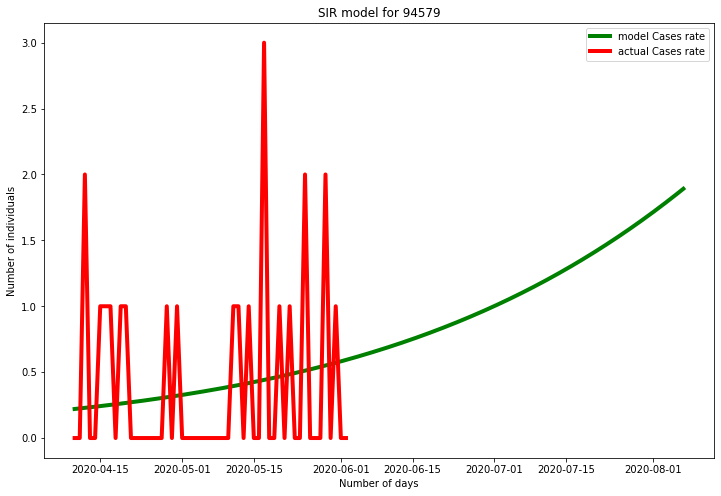

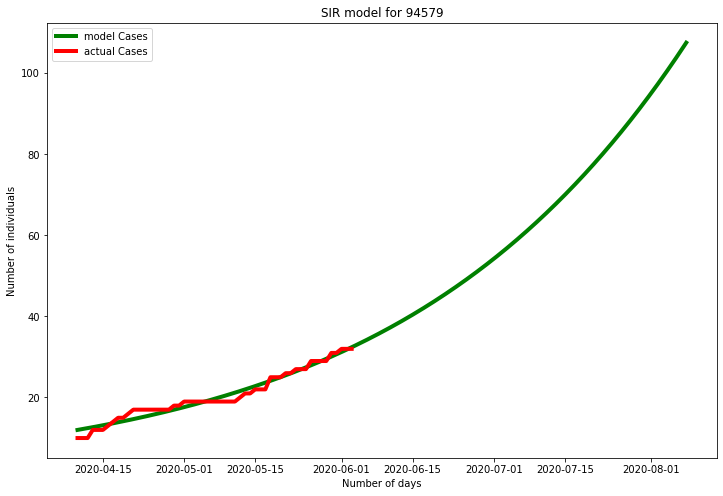

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7485.5
Fraction of infected/recovered population currently infected at start of simulation: 0.5628681612382722
Final population affected (e.g. dead) since start of simulation: 429.25498657097796
Final population affected (e.g. dead) overall: 441.25498657097796
Current and final herd immunity level: 0.0081490882372587 0.058851996424529686
Transmissions per person per day: 0.105025154251963
First day estimate multiplier 0.9401360554032117
R0 (initial transmit rate / recovery rate) 1.05025154251963
R (current transmit rate / recovery rate) 1.0416929500283205
Training MSE 2.4792759432354003
Validation MSE 2.4792759432354003
Date
2020-06-03    1.041693
Name: R, dtype: float64
peak infection rate date 2021-01-17 07:12:00


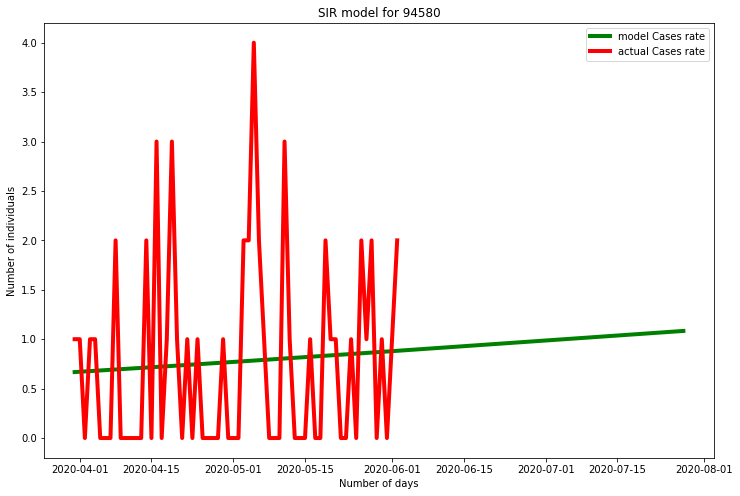

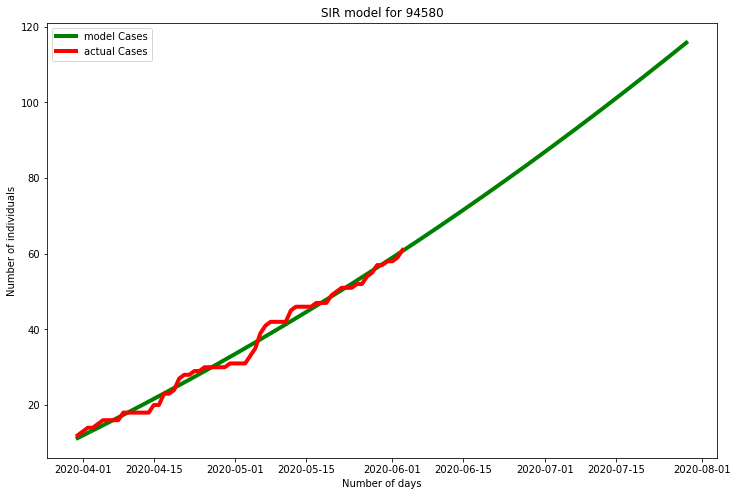

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 18650.25
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 743.1035655626656
Final population affected (e.g. dead) overall: 753.1035655626656
Current and final herd immunity level: 0.0069704159461669414 0.040671513842096836
Transmissions per person per day: 0.10293991316861624
First day estimate multiplier 1.5430335470901408
R0 (initial transmit rate / recovery rate) 1.0293991316861624
R (current transmit rate / recovery rate) 1.0222237915636867
Training MSE 10.950926345147082
Validation MSE 10.950926345147082
Date
2020-06-03    1.022224
Name: R, dtype: float64
peak infection rate date 2020-11-28 19:12:00


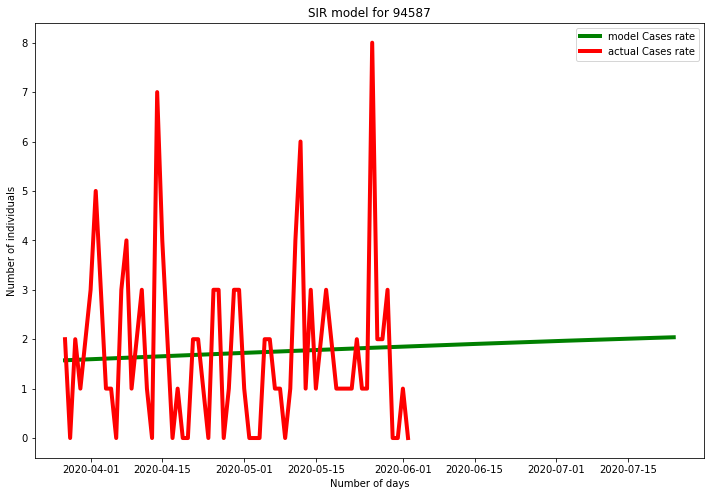

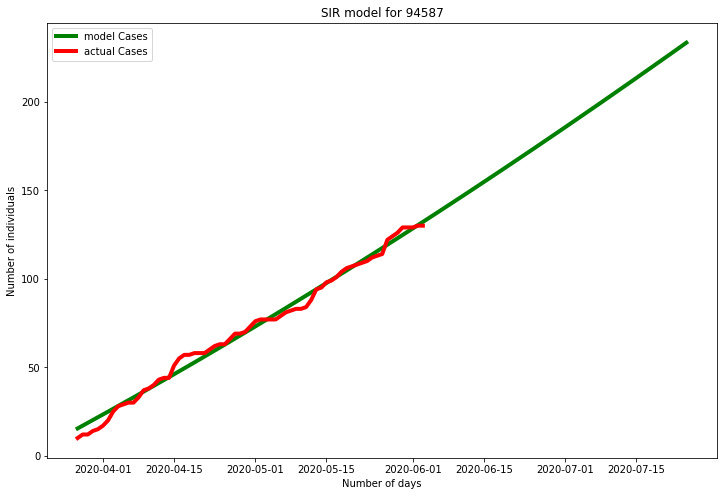

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9079.0
Fraction of infected/recovered population currently infected at start of simulation: 0.1430860060154958
Final population affected (e.g. dead) since start of simulation: 14.796345984143045
Final population affected (e.g. dead) overall: 25.796345984143045
Current and final herd immunity level: 0.0027536072254653594 0.003224400569932728
Transmissions per person per day: 0.08806480319746963
First day estimate multiplier 1.3161806172978214
R0 (initial transmit rate / recovery rate) 0.8806480319746963
R (current transmit rate / recovery rate) 0.878223073190759
Training MSE 1.205781799196446
Validation MSE 1.205781799196446
Date
2020-06-03    0.878223
Name: R, dtype: float64
peak infection rate date 2020-03-31 00:00:00


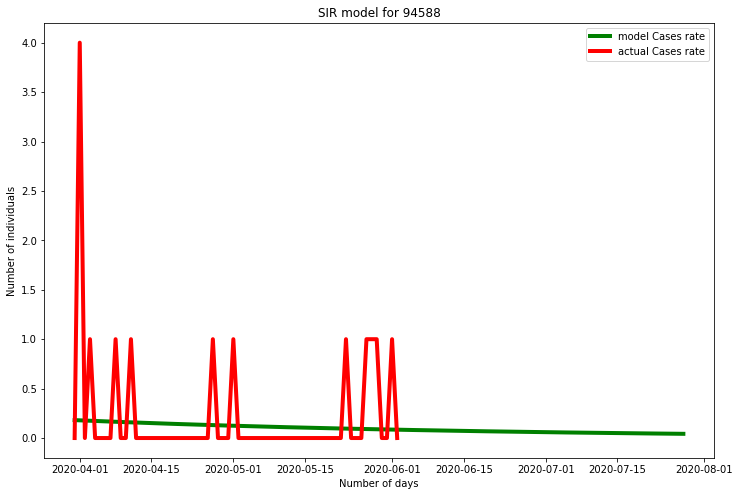

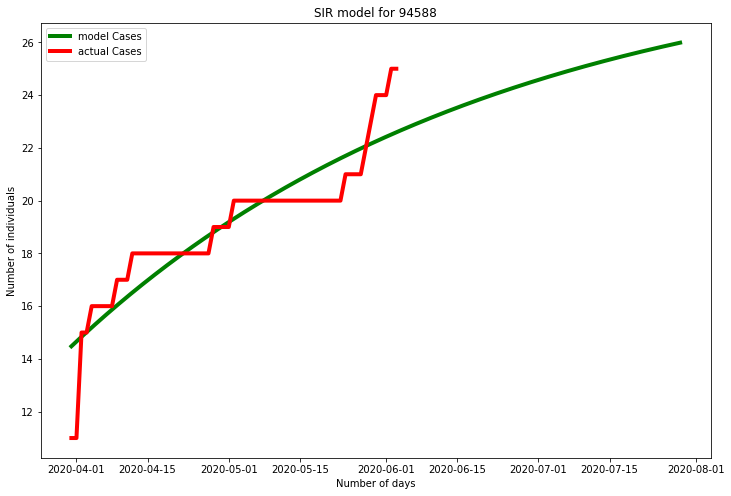

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 13074.75
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 6833.685610895995
Final population affected (e.g. dead) overall: 6843.685610895995
Current and final herd immunity level: 0.031128702269641866 0.5236009913164211
Transmissions per person per day: 0.14143174798409197
First day estimate multiplier 1.2266450318383062
R0 (initial transmit rate / recovery rate) 1.4143174798409197
R (current transmit rate / recovery rate) 1.3702916120962016
Training MSE 80.2124602175032
Validation MSE 80.2124602175032
Date
2020-06-03    1.370292
Name: R, dtype: float64
peak infection rate date 2020-08-04 12:00:00


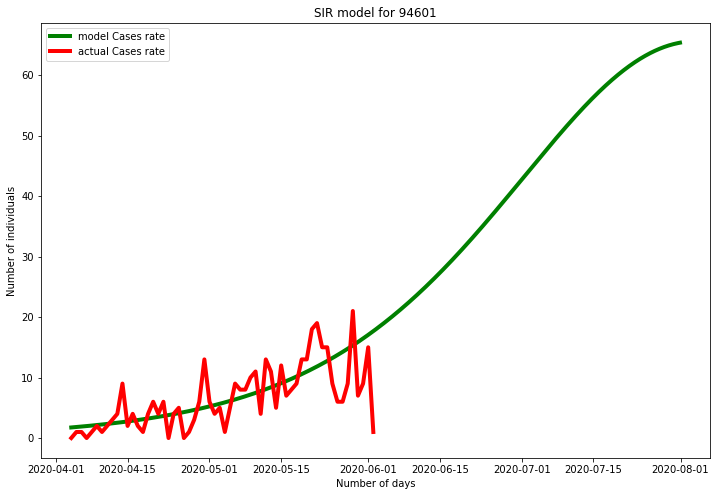

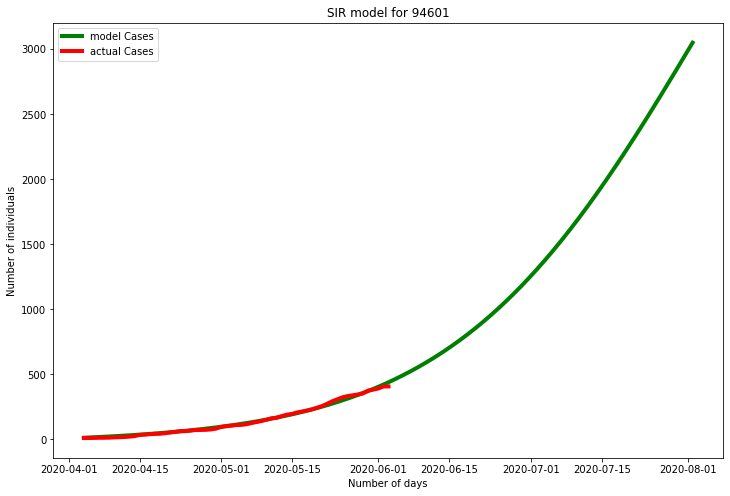

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7483.25
Fraction of infected/recovered population currently infected at start of simulation: 0.09126835091564375
Final population affected (e.g. dead) since start of simulation: 4218.755993414194
Final population affected (e.g. dead) overall: 4229.755993414194
Current and final herd immunity level: 0.006815220659472823 0.5652409219432942
Transmissions per person per day: 0.14745116314778217
First day estimate multiplier 1.0075577925421186
R0 (initial transmit rate / recovery rate) 1.4745116314778217
R (current transmit rate / recovery rate) 1.464462509344341
Training MSE 5.9037834321921485
Validation MSE 5.9037834321921485
Date
2020-06-03    1.464463
Name: R, dtype: float64
peak infection rate date 2020-09-05 09:36:00


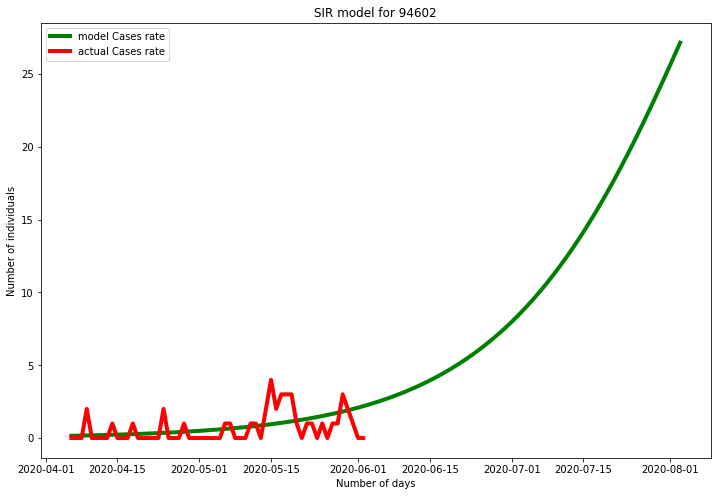

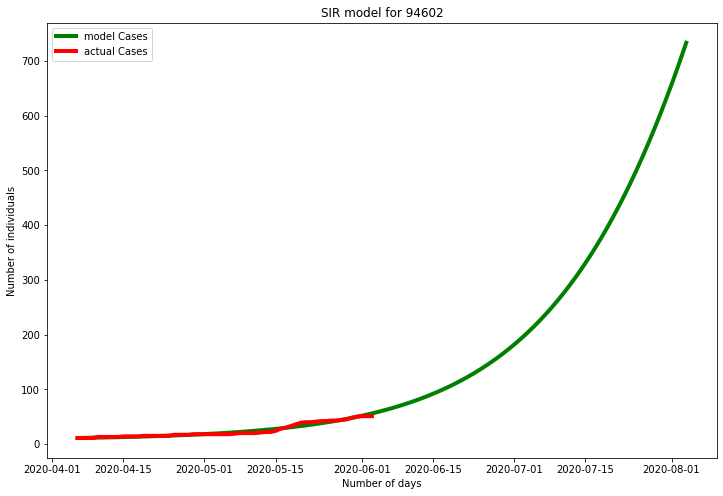

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 8648.25
Fraction of infected/recovered population currently infected at start of simulation: 0.28521106649285455
Final population affected (e.g. dead) since start of simulation: 4374.785754617321
Final population affected (e.g. dead) overall: 4384.785754617321
Current and final herd immunity level: 0.019657156072037694 0.5078547660608489
Transmissions per person per day: 0.13962895960265306
First day estimate multiplier 1.7269225968415578
R0 (initial transmit rate / recovery rate) 1.3962895960265307
R (current transmit rate / recovery rate) 1.3688425135156748
Training MSE 14.10659789125746
Validation MSE 14.10659789125746
Date
2020-06-03    1.368843
Name: R, dtype: float64
peak infection rate date 2020-08-22 16:48:00


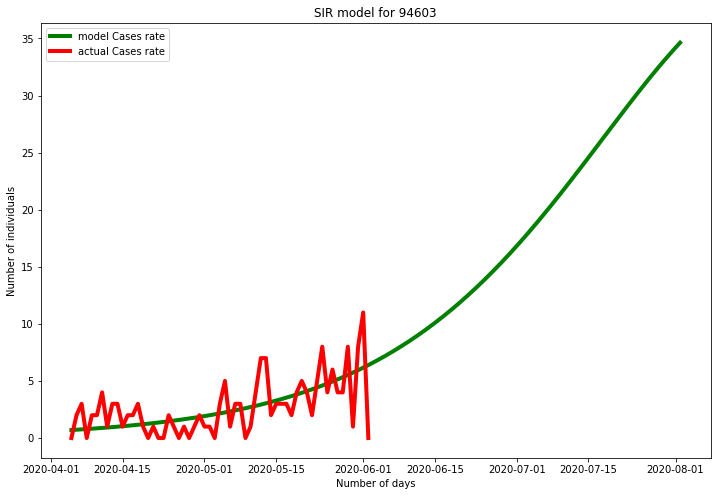

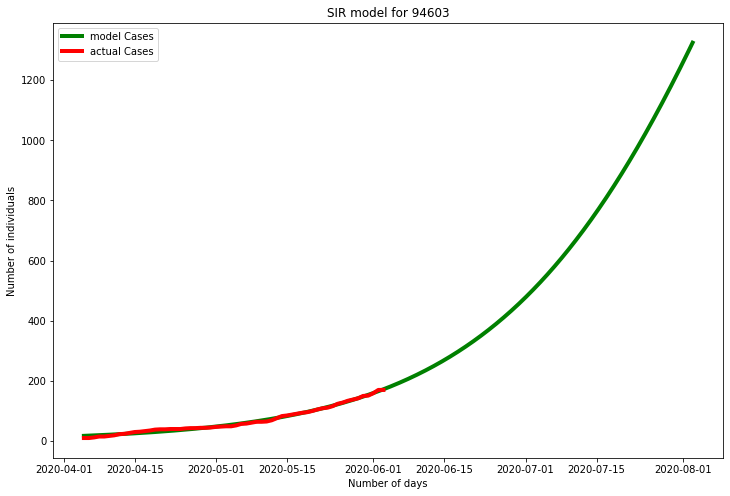

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 10778.0
Fraction of infected/recovered population currently infected at start of simulation: 0.5500483870417628
Final population affected (e.g. dead) since start of simulation: 3335.72176371977
Final population affected (e.g. dead) overall: 3345.72176371977
Current and final herd immunity level: 0.011968825385043607 0.31060090249502637
Transmissions per person per day: 0.12115605988357618
First day estimate multiplier 1.1934763371623944
R0 (initial transmit rate / recovery rate) 1.2115605988357618
R (current transmit rate / recovery rate) 1.1970596415848977
Training MSE 5.542040358844426
Validation MSE 5.542040358844426
Date
2020-06-03    1.19706
Name: R, dtype: float64
peak infection rate date 2020-10-23 14:24:00


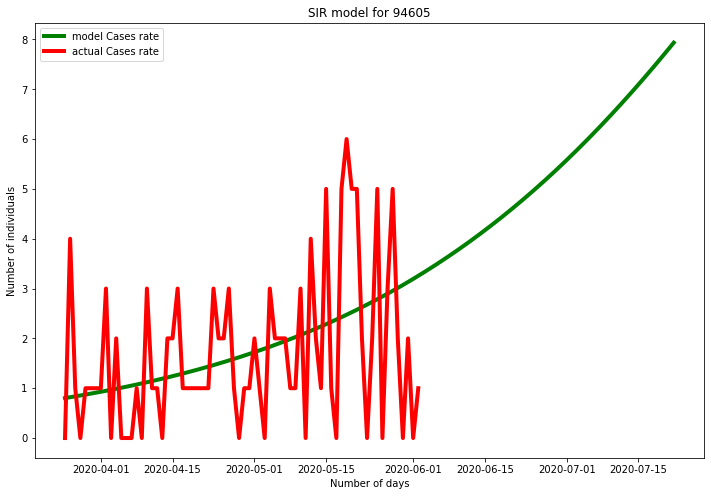

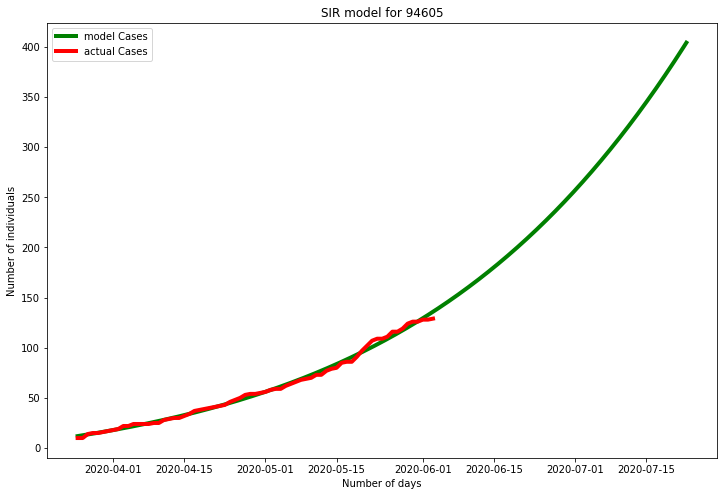

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9575.75
Fraction of infected/recovered population currently infected at start of simulation: 0.38671908887870743
Final population affected (e.g. dead) since start of simulation: 4632.733096929712
Final population affected (e.g. dead) overall: 4642.733096929712
Current and final herd immunity level: 0.010860768086050701 0.484761279886837
Transmissions per person per day: 0.13686947427969506
First day estimate multiplier 0.921972894666874
R0 (initial transmit rate / recovery rate) 1.3686947427969507
R (current transmit rate / recovery rate) 1.3538296666148362
Training MSE 16.057362225458295
Validation MSE 16.057362225458295
Date
2020-06-03    1.35383
Name: R, dtype: float64
peak infection rate date 2020-09-09 21:36:00


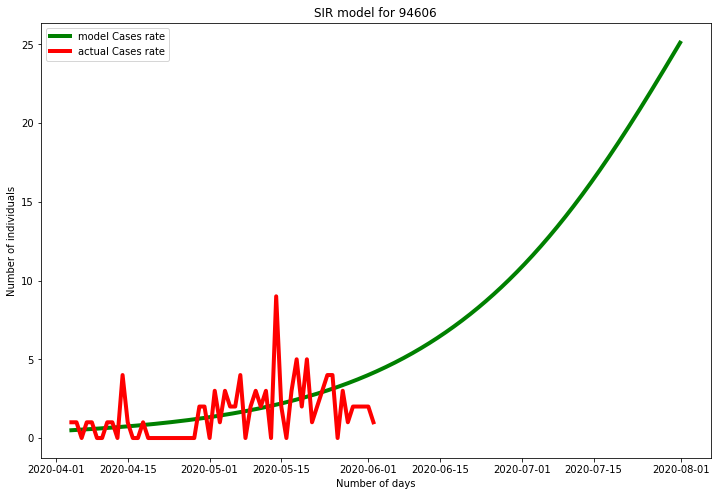

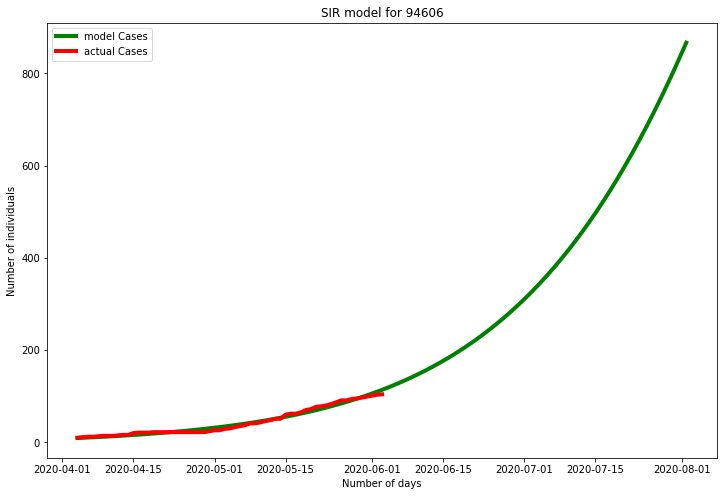

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 6563.5
Fraction of infected/recovered population currently infected at start of simulation: 0.7492930313232543
Final population affected (e.g. dead) since start of simulation: 315.6482235083049
Final population affected (e.g. dead) overall: 325.6482235083049
Current and final herd immunity level: 0.007922602270130266 0.04943363065714342
Transmissions per person per day: 0.10321287625211514
First day estimate multiplier 0.8809411309855462
R0 (initial transmit rate / recovery rate) 1.0321287625211515
R (current transmit rate / recovery rate) 1.0239516168441347
Training MSE 3.7644535035602873
Validation MSE 3.7644535035602873
Date
2020-06-03    1.023952
Name: R, dtype: float64
peak infection rate date 2020-11-09 09:36:00


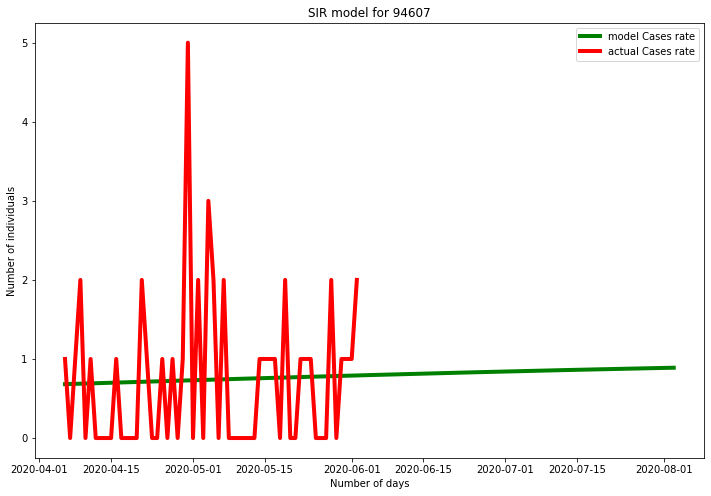

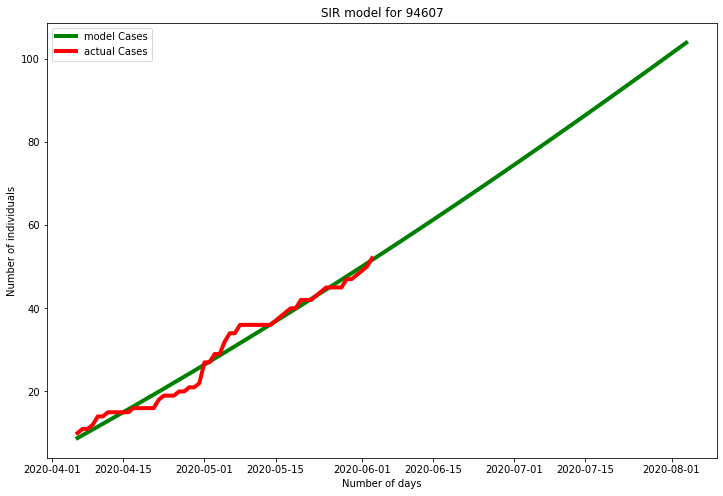

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7572.25
Fraction of infected/recovered population currently infected at start of simulation: 0.28298831950504055
Final population affected (e.g. dead) since start of simulation: 813.2511139612634
Final population affected (e.g. dead) overall: 823.2511139612634
Current and final herd immunity level: 0.004622140050843541 0.10863495033474702
Transmissions per person per day: 0.11175458007433635
First day estimate multiplier 0.9359888711024906
R0 (initial transmit rate / recovery rate) 1.1175458007433634
R (current transmit rate / recovery rate) 1.1123803475390956
Training MSE 0.6351561777454338
Validation MSE 0.6351561777454338
Date
2020-06-03    1.11238
Name: R, dtype: float64
peak infection rate date 2021-03-14 04:48:00


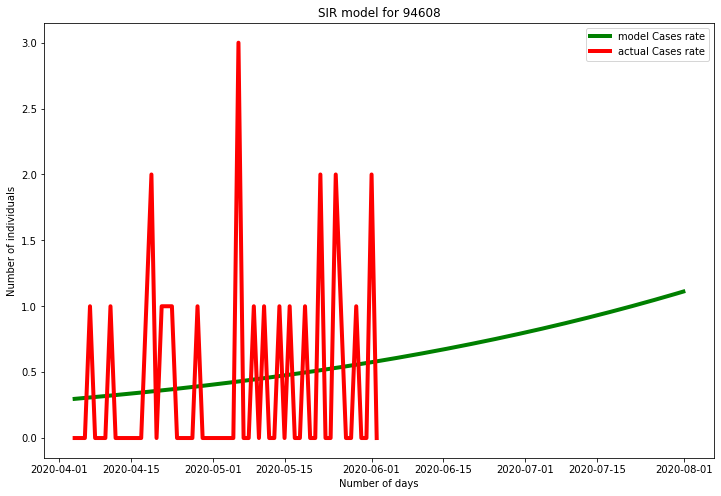

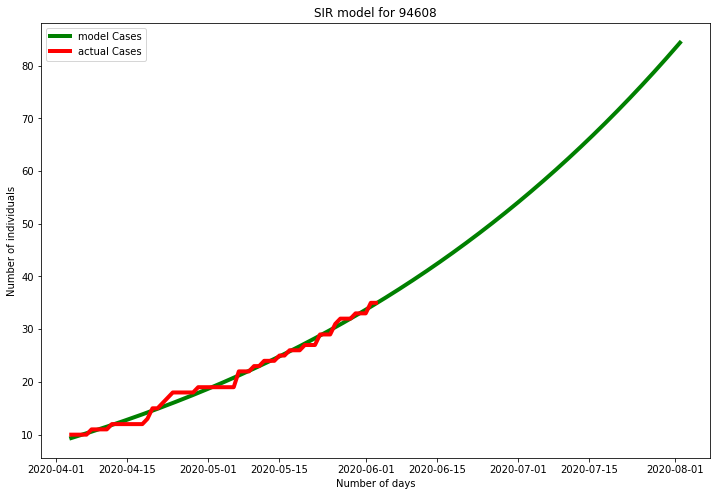

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 5702.75
Fraction of infected/recovered population currently infected at start of simulation: 0.01
Final population affected (e.g. dead) since start of simulation: 5550.3024683975755
Final population affected (e.g. dead) overall: 5560.3024683975755
Current and final herd immunity level: 0.0021042479505501734 0.9749753525992676
Transmissions per person per day: 0.37696357600997926
First day estimate multiplier 0.9738223637897839
R0 (initial transmit rate / recovery rate) 3.7696357600997925
R (current transmit rate / recovery rate) 3.7617035117772817
Training MSE 0.17011687128286843
Validation MSE 0.17011687128286843
Date
2020-06-03    3.761704
Name: R, dtype: float64
peak infection rate date 2020-06-30 19:12:00


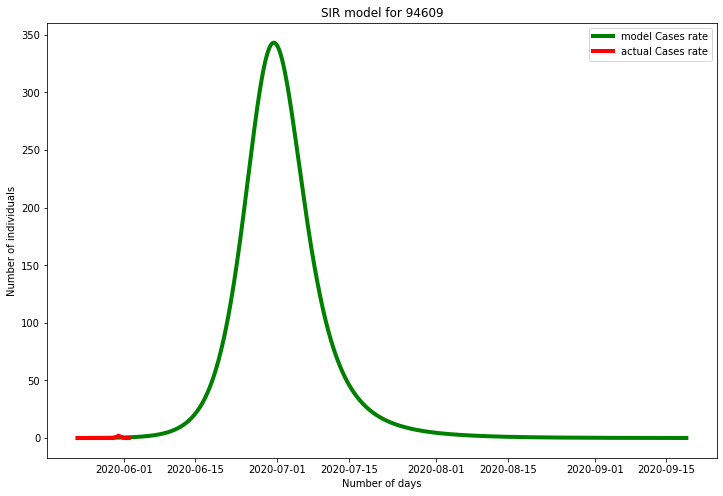

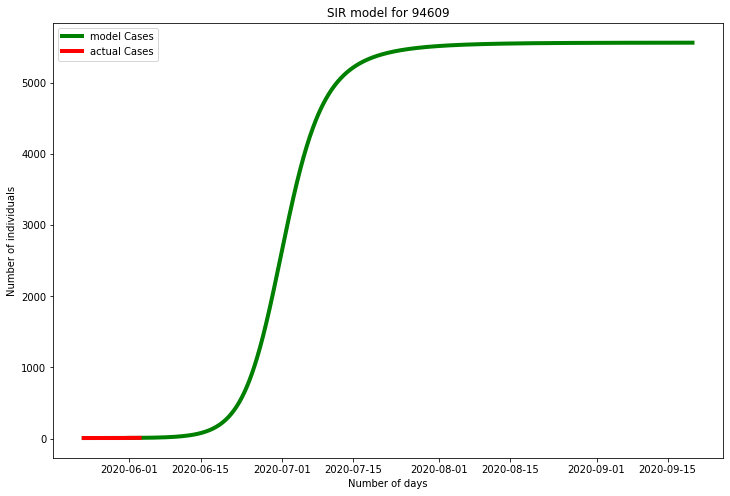

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7874.0
Fraction of infected/recovered population currently infected at start of simulation: 0.3010502573287817
Final population affected (e.g. dead) since start of simulation: 142.82962690428303
Final population affected (e.g. dead) overall: 152.82962690428303
Current and final herd immunity level: 0.004064008128016256 0.0195004304987301
Transmissions per person per day: 0.10180123236451412
First day estimate multiplier 1.0716762842717593
R0 (initial transmit rate / recovery rate) 1.0180123236451413
R (current transmit rate / recovery rate) 1.0138751132874266
Training MSE 1.3978099254591532
Validation MSE 1.3978099254591532
Date
2020-06-03    1.013875
Name: R, dtype: float64
peak infection rate date 2021-02-18 16:48:00


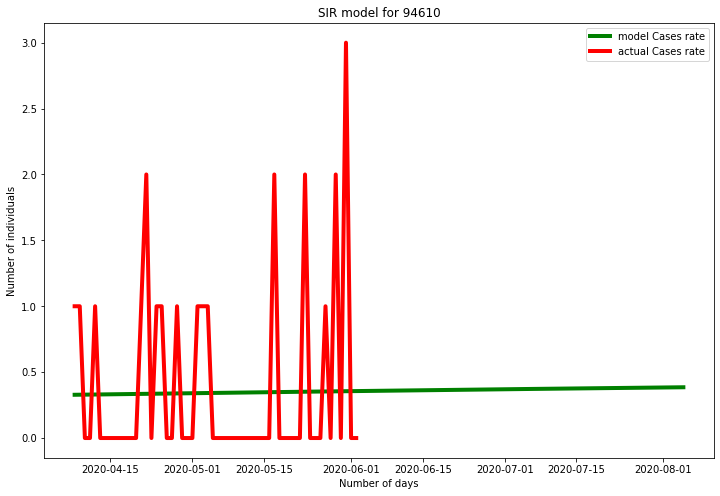

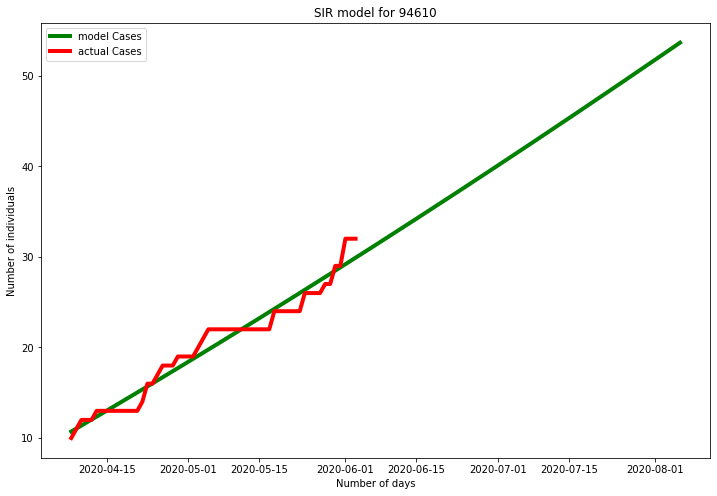

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9846.0
Fraction of infected/recovered population currently infected at start of simulation: 0.27721430657933127
Final population affected (e.g. dead) since start of simulation: 61.64580313909573
Final population affected (e.g. dead) overall: 71.64580313909573
Current and final herd immunity level: 0.004468819825309771 0.007857896474893536
Transmissions per person per day: 0.09456552436099626
First day estimate multiplier 1.572304555270707
R0 (initial transmit rate / recovery rate) 0.9456552436099626
R (current transmit rate / recovery rate) 0.9414292807094102
Training MSE 6.1279874866768544
Validation MSE 6.1279874866768544
Date
2020-06-03    0.941429
Name: R, dtype: float64
peak infection rate date 2020-03-23 00:00:00


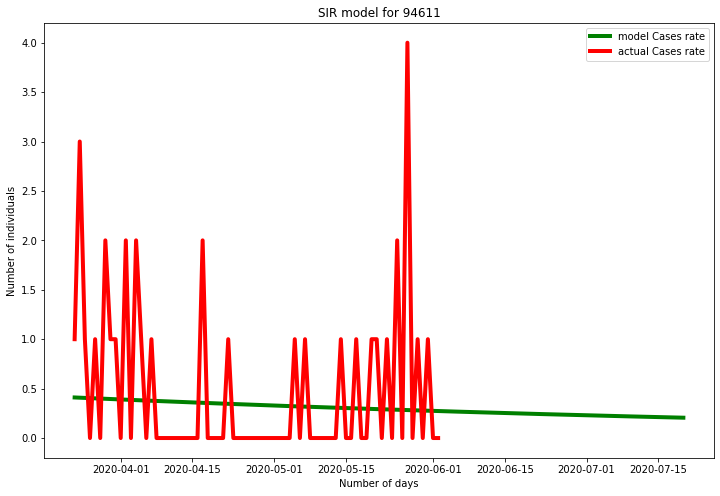

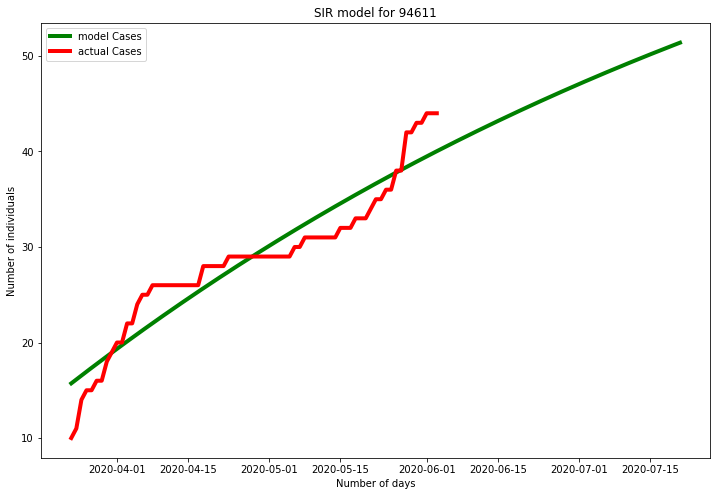

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 4015.5
Fraction of infected/recovered population currently infected at start of simulation: 0.4215565087496678
Final population affected (e.g. dead) since start of simulation: 33.663627480904324
Final population affected (e.g. dead) overall: 43.663627480904324
Current and final herd immunity level: 0.005478769767152285 0.010676182116034527
Transmissions per person per day: 0.0904772318905878
First day estimate multiplier 0.9206581806032319
R0 (initial transmit rate / recovery rate) 0.9047723189058781
R (current transmit rate / recovery rate) 0.8998152796789002
Training MSE 0.5570869856835577
Validation MSE 0.5570869856835577
Date
2020-06-03    0.899815
Name: R, dtype: float64
peak infection rate date 2020-04-17 00:00:00


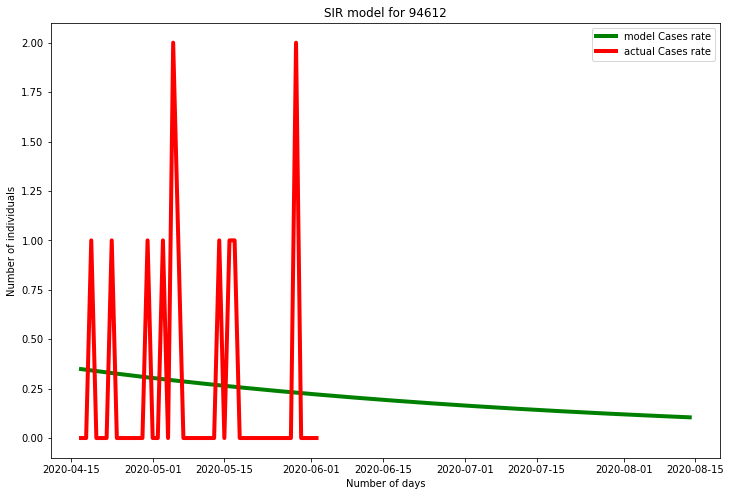

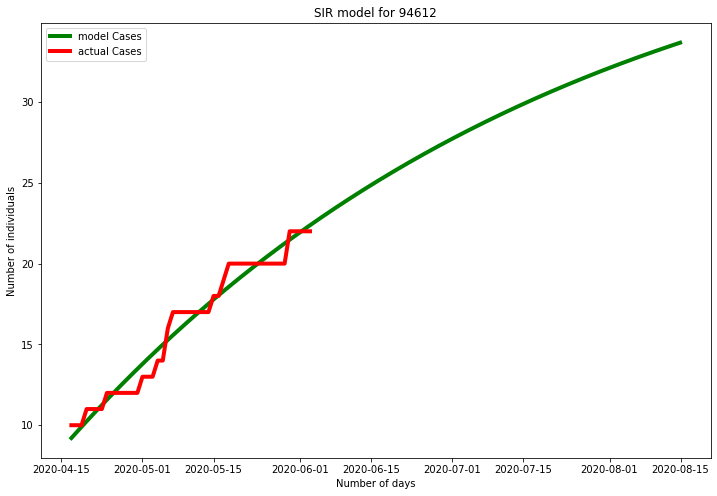

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 6077.0
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 370.20062772837537
Final population affected (e.g. dead) overall: 381.20062772837537
Current and final herd immunity level: 0.019582030607207503 0.06401038045213775
Transmissions per person per day: 0.09941531831170873
First day estimate multiplier 1.708223116296858
R0 (initial transmit rate / recovery rate) 0.9941531831170873
R (current transmit rate / recovery rate) 0.9746856450570357
Training MSE 133.696360074776
Validation MSE 133.69636007477604
Date
2020-06-03    0.974686
Name: R, dtype: float64
peak infection rate date 2020-04-01 00:00:00


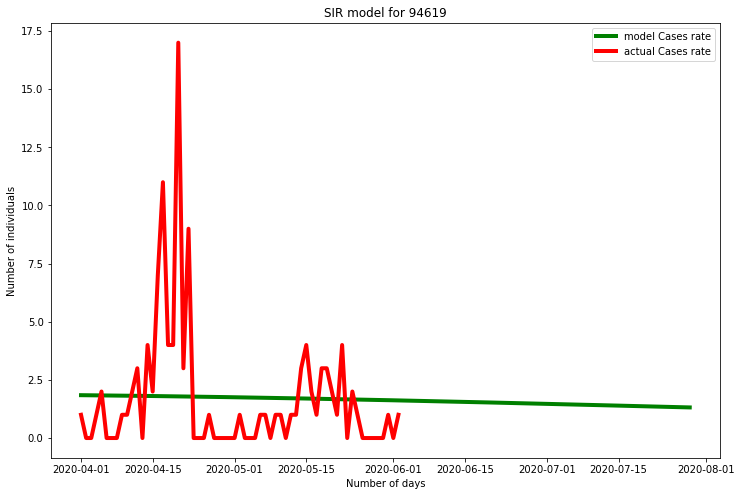

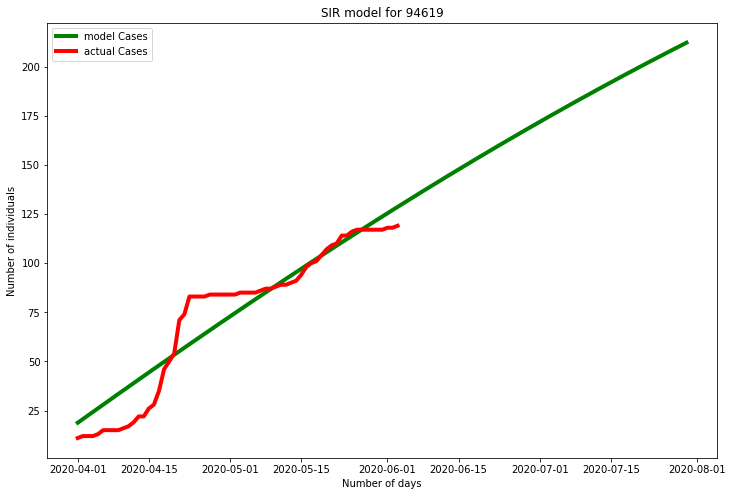

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 8821.75
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 2353.806293334993
Final population affected (e.g. dead) overall: 2364.806293334993
Current and final herd immunity level: 0.021310964377816193 0.2684884782863288
Transmissions per person per day: 0.11696637622564607
First day estimate multiplier 1.339267271584458
R0 (initial transmit rate / recovery rate) 1.1696637622564607
R (current transmit rate / recovery rate) 1.1447370994849908
Training MSE 14.103298024011776
Validation MSE 14.103298024011776
Date
2020-06-03    1.144737
Name: R, dtype: float64
peak infection rate date 2020-09-29 00:00:00


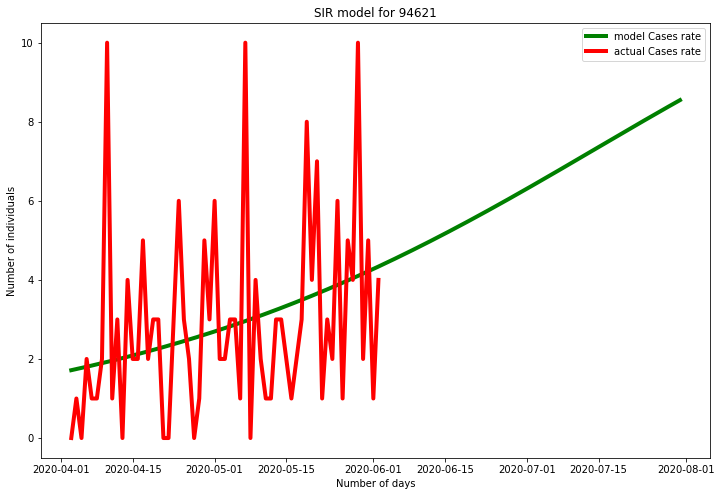

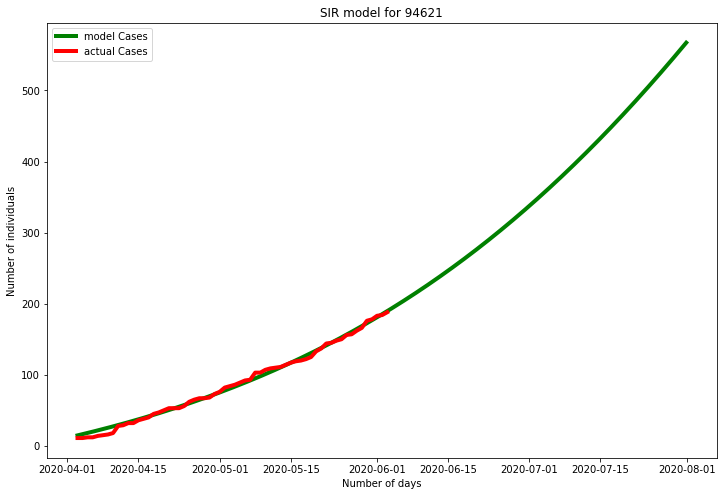

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 4273.0
Fraction of infected/recovered population currently infected at start of simulation: 0.18462320547662714
Final population affected (e.g. dead) since start of simulation: 1814.189223554989
Final population affected (e.g. dead) overall: 1824.189223554989
Current and final herd immunity level: 0.005382635150947812 0.4271371096204549
Transmissions per person per day: 0.13080890821843336
First day estimate multiplier 1.0967645853214734
R0 (initial transmit rate / recovery rate) 1.3080890821843336
R (current transmit rate / recovery rate) 1.3010481159099971
Training MSE 0.40653126167413906
Validation MSE 0.40653126167413906
Date
2020-06-03    1.301048
Name: R, dtype: float64
peak infection rate date 2020-10-25 14:24:00


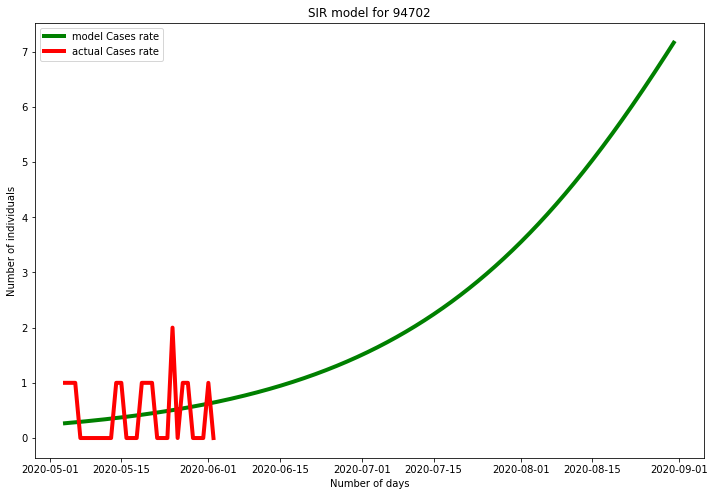

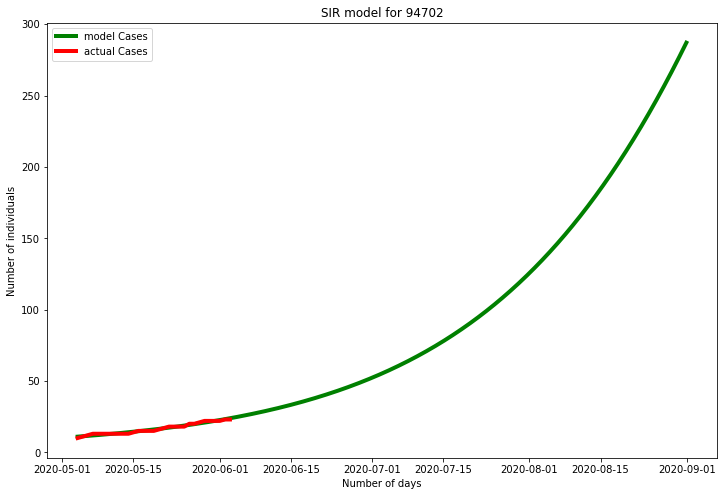

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 5484.25
Fraction of infected/recovered population currently infected at start of simulation: 0.2035450958192608
Final population affected (e.g. dead) since start of simulation: 2333.0229938952107
Final population affected (e.g. dead) overall: 2343.0229938952107
Current and final herd immunity level: 0.006928932853170443 0.42698372438914395
Transmissions per person per day: 0.13089330008016203
First day estimate multiplier 0.8662496585951676
R0 (initial transmit rate / recovery rate) 1.3089330008016202
R (current transmit rate / recovery rate) 1.299863491929767
Training MSE 3.50163174866963
Validation MSE 3.50163174866963
Date
2020-06-03    1.299863
Name: R, dtype: float64
peak infection rate date 2020-10-12 16:48:00


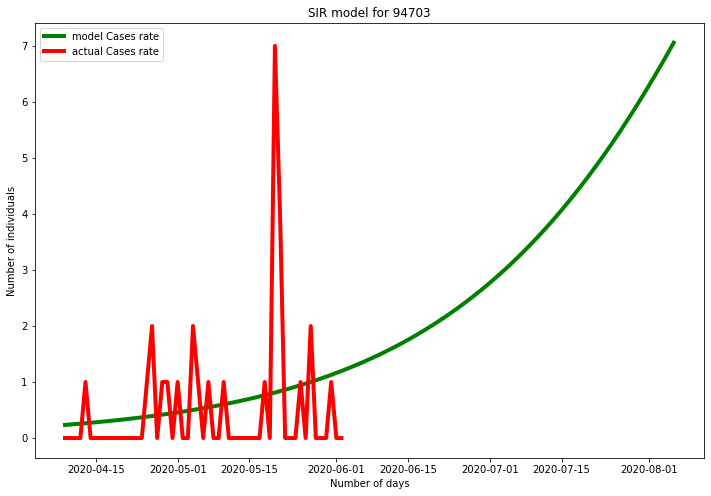

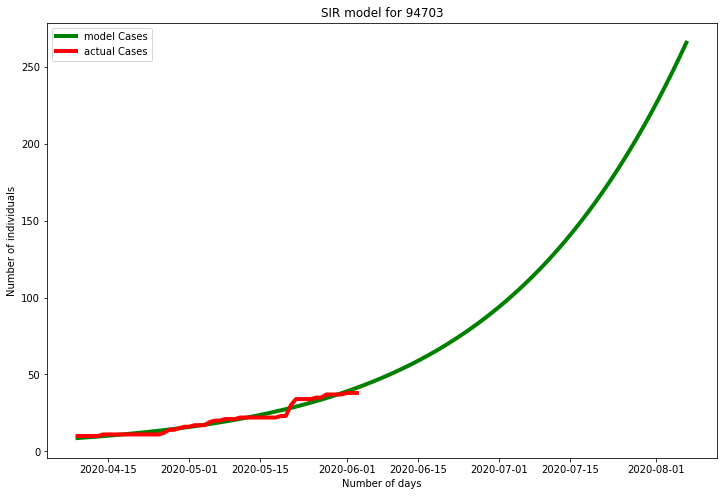

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7297.5
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 1.6174205646557311
Final population affected (e.g. dead) overall: 11.617420564655731
Current and final herd immunity level: 0.0015073655361425146 0.0015867505172007398
Transmissions per person per day: 0.014110225128659778
First day estimate multiplier 0.9961891334616694
R0 (initial transmit rate / recovery rate) 0.14110225128659779
R (current transmit rate / recovery rate) 0.14088955861593624
Training MSE 0.056406645775009236
Validation MSE 0.056406645775009236
Date
2020-06-03    0.14089
Name: R, dtype: float64
peak infection rate date 2020-05-17 00:00:00


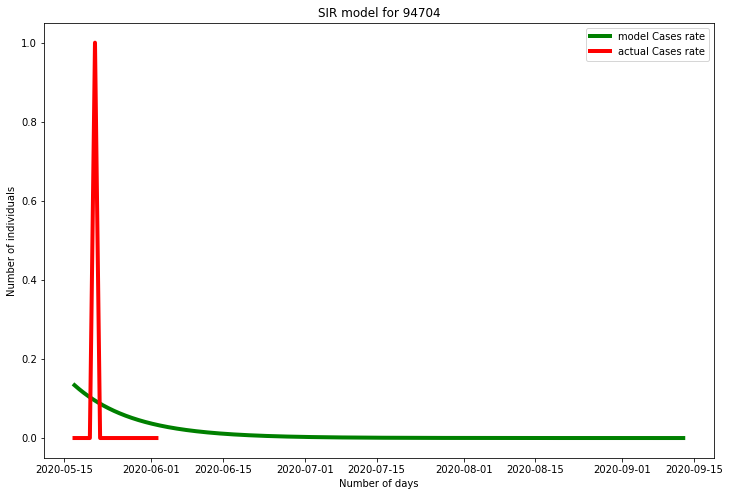

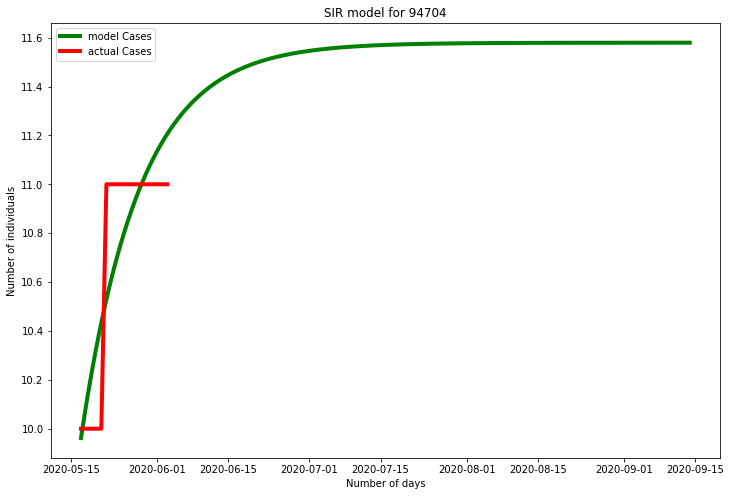

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 5260.0
Fraction of infected/recovered population currently infected at start of simulation: 0.010000000000000004
Final population affected (e.g. dead) since start of simulation: 0.0010081399877890362
Final population affected (e.g. dead) overall: 10.001008139987789
Current and final herd immunity level: 0.0019011406844106464 0.001901292296125807
Transmissions per person per day: 0.0010000000000000002
First day estimate multiplier 0.9999789337634465
R0 (initial transmit rate / recovery rate) 0.010000000000000002
R (current transmit rate / recovery rate) 0.009980988593155896
Training MSE 1.823846861776746e-08
Validation MSE 1.823846861776746e-08
Date
2020-06-03    0.009981
Name: R, dtype: float64
peak infection rate date 2020-05-29 00:00:00


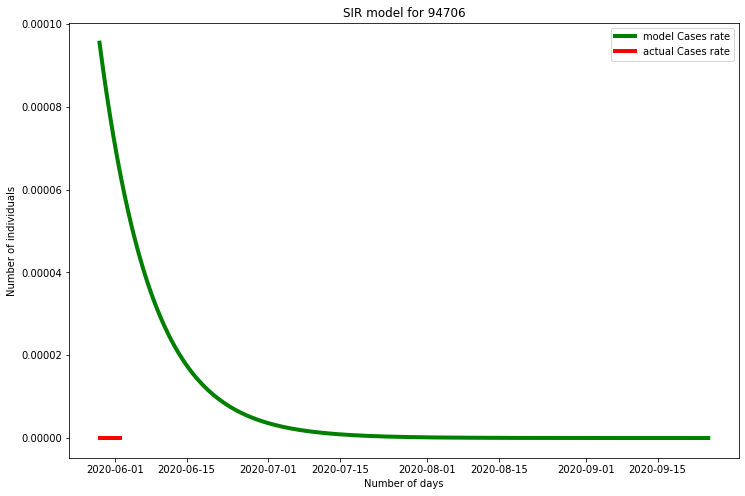

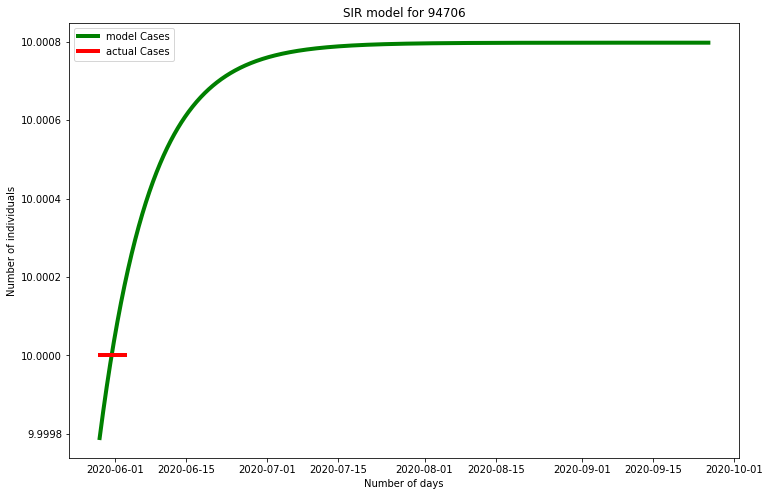

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 1865.25
Fraction of infected/recovered population currently infected at start of simulation: 0.03346146282935483
Final population affected (e.g. dead) since start of simulation: 1854.8189656393322
Final population affected (e.g. dead) overall: 1864.8189656393322
Current and final herd immunity level: 0.00589733279721217 0.9996916448530428
Transmissions per person per day: 0.8
First day estimate multiplier 0.9855874922806056
R0 (initial transmit rate / recovery rate) 8.0
R (current transmit rate / recovery rate) 7.952821337622303
Training MSE 0.02452959019291694
Validation MSE 0.02452959019291694
Date
2020-06-03    7.952821
Name: R, dtype: float64
peak infection rate date 2020-06-13 12:00:00


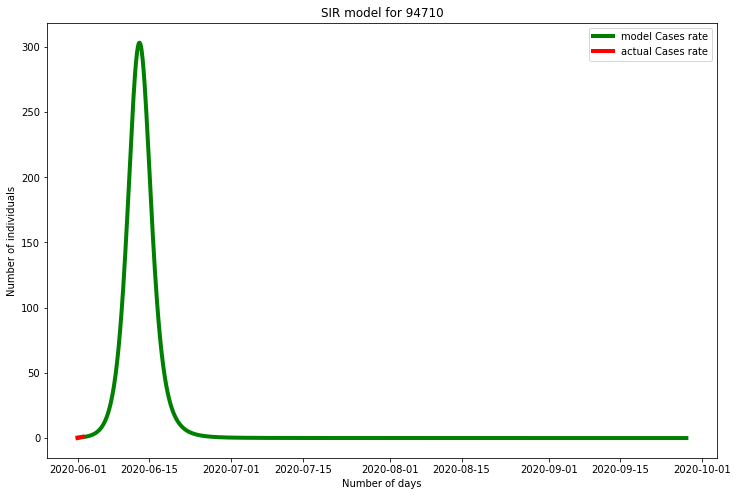

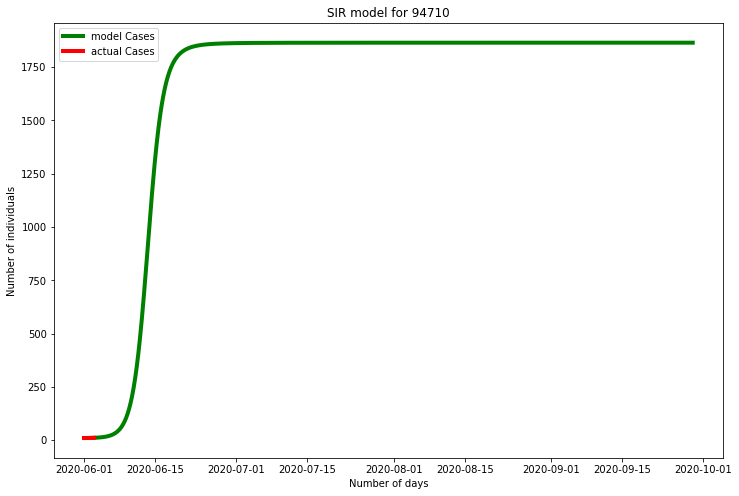

In [460]:
SAMPLING_RATE = 10
SIMULATION_DAYS = 360
VISUALIZATION_DAYS = 120
METRIC = 'Cases'
locations_with_cases['R'] = 0.0
locations_with_cases['Final cases'] = 0.0
locations_with_cases['MSE'] = 0.0

for area in locations_with_cases['Location'].unique():
    area_df = alameda_df[alameda_df['Location'] == str(area)]
    population = pop_df[pop_df.index == str(area)]['population'].iloc[0]
    # Calculate R for zip code or region


    train_area_df = area_df[area_df[METRIC] > 0]

    train_data = dataproc.convert_data_to_numpy(train_area_df, METRIC, smooth=False)


    # Reasonable search regions for each parameter
    pop_frac = 0.25
    recovery_days = 10.0 # This is fairly constant
    infection_rate_range = [0.001, 0.80]
    multiplier_range = [0.01, 10.0]
    frac_infected_range = [0.01, 0.99]

    best_param, best_value = optimizer.minimize(
        train_data, population, recovery_days,
        pop_frac, infection_rate_range, multiplier_range, frac_infected_range
    )

    #Validation plot
    validation_area_df = train_area_df

    best_infection_rate = best_param[0]
    best_multiplier = best_param[1]
    best_frac_infected = best_param[2]

    infected = train_data[0] * best_multiplier * best_frac_infected
    recovered = train_data[0] * best_multiplier * (1 - best_frac_infected)
    t, s, i, r = sir_model.compute_sir(
        SAMPLING_RATE,
        SIMULATION_DAYS,
        population * pop_frac,
        infected,
        recovered,
        best_infection_rate,
        recovery_days
    )

    valid_obj = sir_model.create_objective_fn(
        validation_area_df[METRIC].to_numpy(), population, sampling_rate=SAMPLING_RATE)

    validation_mse = valid_obj(pop_frac, best_infection_rate, recovery_days, best_multiplier, best_frac_infected)

    print('Population fraction susceptible (e.g. would die if infected):', pop_frac)
    print('Population susceptible (e.g. would die if infected):', pop_frac * population)
    print('Fraction of infected/recovered population currently infected at start of simulation:', best_frac_infected)
    print('Final population affected (e.g. dead) since start of simulation:', (s[0] - s[-1]))
    print('Final population affected (e.g. dead) overall:', (train_area_df[METRIC].iloc[0] + s[0] - s[-1]))
    print('Current and final herd immunity level:',
          train_data[-1] / pop_frac / population,
          (population * pop_frac - s[-1]) / pop_frac / population)
    print('Transmissions per person per day:', best_infection_rate)
    print('First day estimate multiplier', best_multiplier)
    print('R0 (initial transmit rate / recovery rate)', best_infection_rate * recovery_days)
    print('R (current transmit rate / recovery rate)', best_infection_rate * recovery_days * (1 - train_data[-1] / pop_frac / population))
    locations_with_cases.loc[locations_with_cases['Location'] == str(area), 'R'] = best_infection_rate * recovery_days * (1 - train_data[-1] / pop_frac / population)
    locations_with_cases.loc[locations_with_cases['Location'] == str(area), 'Final cases'] = (train_area_df[METRIC].iloc[0] + s[0] - s[-1])
    locations_with_cases.loc[locations_with_cases['Location'] == str(area), 'MSE'] = best_value
    
    print('Training MSE', best_value)
    print('Validation MSE', validation_mse)
    print(locations_with_cases[locations_with_cases['Location'] == str(area)]['R'])
    plot_sir_model(r, i, s, SIMULATION_DAYS, VISUALIZATION_DAYS, validation_area_df, METRIC, SAMPLING_RATE, area)

In [463]:
# Derived metrics
locations_with_cases['Final frac cases'] = locations_with_cases['Final cases'] / locations_with_cases['population']
locations_with_cases['Bart stops'] = locations_with_cases['Bart entries'] + locations_with_cases['Bart exits']


In [471]:
# Demographics
demographics_df = pd.read_csv('data_repo/alameda_demographics/demographics_by_zip_code.csv')
demographics_df['Location'] = demographics_df['Location'].astype(str)
demographics_df = demographics_df.set_index('Location')
demographics_df['Fraction of population that is Black or Other'] = (
    demographics_df['Fraction of population that is Black']
    + demographics_df['Fraction of population that is Other']
)
demographics_df['Fraction of population that is Asian or White'] = (
    demographics_df['Fraction of population that is Asian']
    + demographics_df['Fraction of population that is White']
)

demographics_df['Fraction of population that is Non-Asian and Non-White'] = (
    1 - demographics_df['Fraction of population that is Asian or White']
)

demographics_df['Fraction of Non-Asian population that is Non-White'] = (
    (1 - demographics_df['Fraction of population that is Asian']
     - demographics_df['Fraction of population that is White']) /
    (1 - demographics_df['Fraction of population that is Asian'])
)
demographics_df['Fraction non-white collar'] = 1 - demographics_df['White collar fraction']

In [ ]:
# Join with locations
locations_with_cases = locations_with_cases.join(demographics_df, on='Location', how='left')

In [464]:
# Save the dataframe for later!
locations_with_cases.to_pickle('data/alameda_cases.pkl')

In [454]:
# Load the dataframe for visualizations
locations_with_cases = pd.read_pickle('data/alameda_cases.pkl')

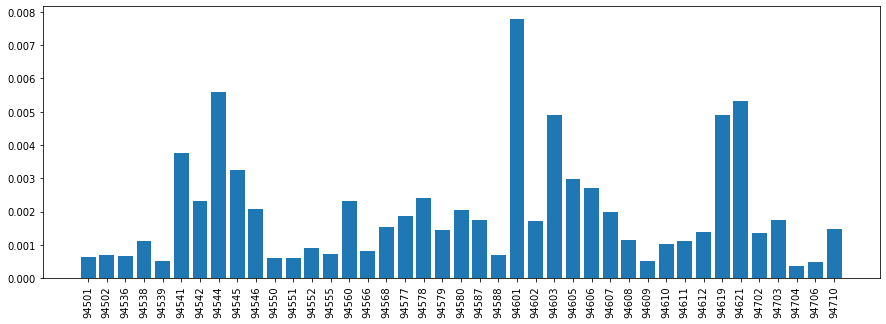

In [455]:
plt.figure(figsize=(15,5))
plt.bar(locations_with_cases['Location'], locations_with_cases['Frac Cases'])
plt.xticks(rotation=90)
plt.show()


In [456]:
def poly_line(x, coef):
    y = np.zeros_like(x, dtype=np.float64)
    for p in range(len(coef)):
        y += np.power(x, p) * coef[-(p + 1)]
    return y

In [457]:
# Function to plot trend line
def power_law_plot(df, x_col, y_col, x_log_scale=True, y_log_scale=True, save_fig_path=''):
    df = df[~df[x_col].isna()]
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()
    log_x = np.log(x)
    log_y = np.log(y)
    coef = np.polyfit(log_x, log_y, w=y + 25, deg=1)    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(df[x_col],
               df[y_col],
               label='data')
    trend_line_x = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(trend_line_x, np.exp(poly_line(np.log(trend_line_x), coef)), label='fitted line', linewidth=4)

    texts = zip(df[x_col].tolist(),
                df[y_col].tolist(),
                (df['city'] + ', ' + df['Location']).tolist())
    texts = [plt.text(x, y, t) for (x, y, t) in texts]

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if x_log_scale:
        ax.set_xscale('log')
    if y_log_scale:
        ax.set_yscale('log')
    formatter = ScalarFormatter()
    formatter = FormatStrFormatter('%.2g')
#    formatter.set_scientific(True)
#     formatter.set_powerlimits((-1, 1))
    ax.get_xaxis().set_minor_formatter(formatter)
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_minor_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    plt.xticks(rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    #ax.get_xaxis().set_minor_formatter(ax.get_xaxis().get_major_formatter())

#    ax.get_yaxis().get_major_formatter().labelOnlyBase = False
    #adjust_text(texts, autoalign='', only_move={'points':'y', 'text':'y'})#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    #plt.loglog()
#    ax.locator_params(tight=True, nbins=10)
#     ax.locator_params(axis='x', nbins=10)
#     ax.locator_params(axis='y', nbins=10)
#     ax.set_xticks(np.exp(np.linspace(np.log(x_range[0]), np.log(x_range[-1]), 10)))
#     ax.xaxis.set_major_formatter(ScalarFormatter())
#     ax.set_yticks(np.exp(np.linspace(np.log(np.min(y)), np.log(np.max(y)), 10)))
#     ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.legend()
    ax.set_title(x_col + ' vs ' + y_col + ' (power {:.2f}, pearson corr {:.2f}, p-value {:.2f})'.format(
        coef[0], *pearsonr(x, y)))
    plt.show()
    if save_fig_path:
        plt.savefig(os.path.join(save_fig_path, x_col + ' vs ' + y_col))
        
    return ax

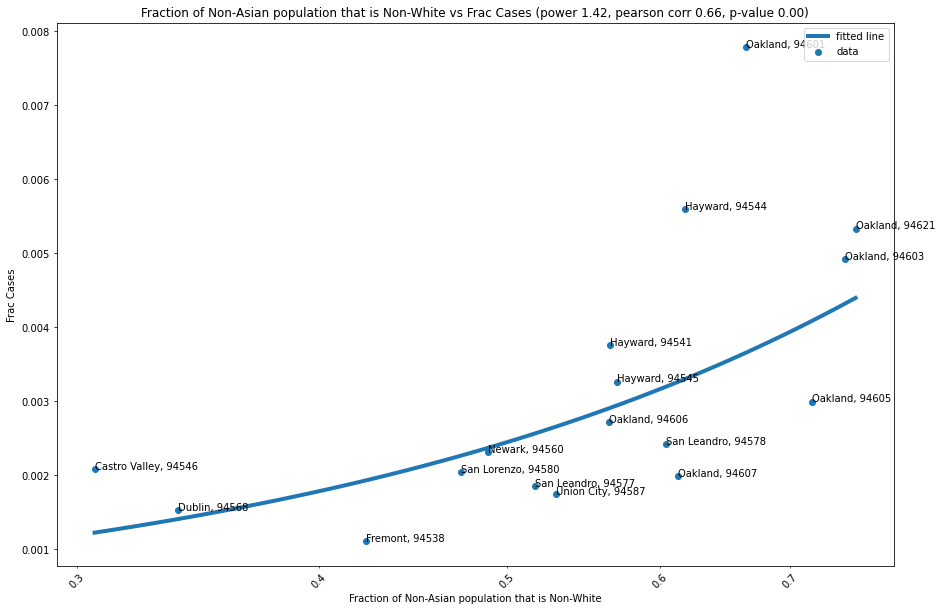

<Figure size 432x288 with 0 Axes>

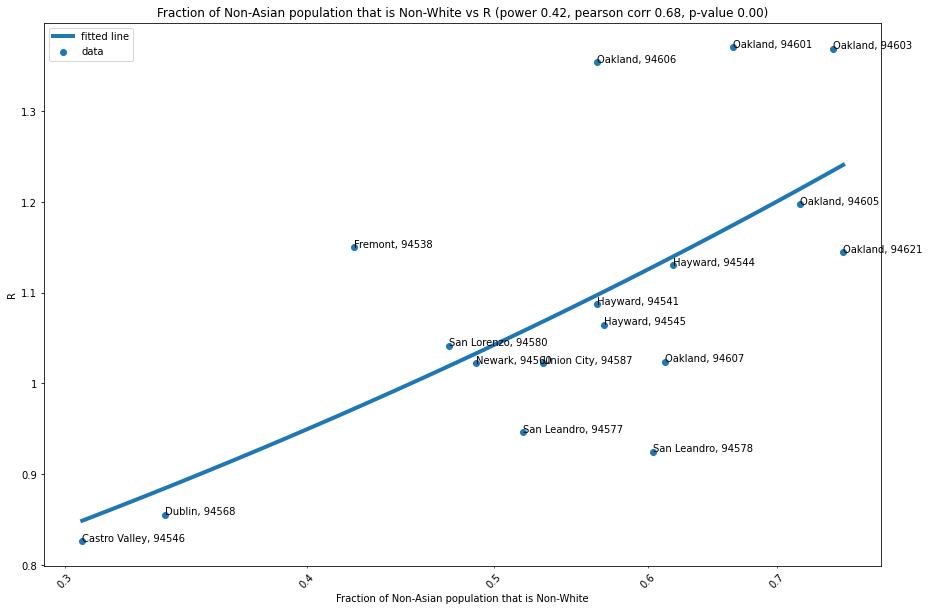

<Figure size 432x288 with 0 Axes>

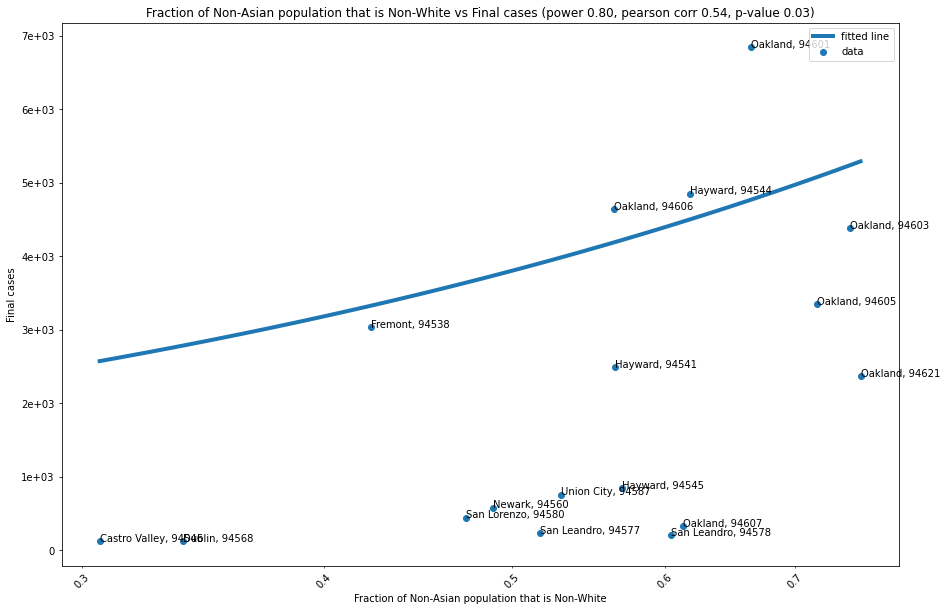

<Figure size 432x288 with 0 Axes>

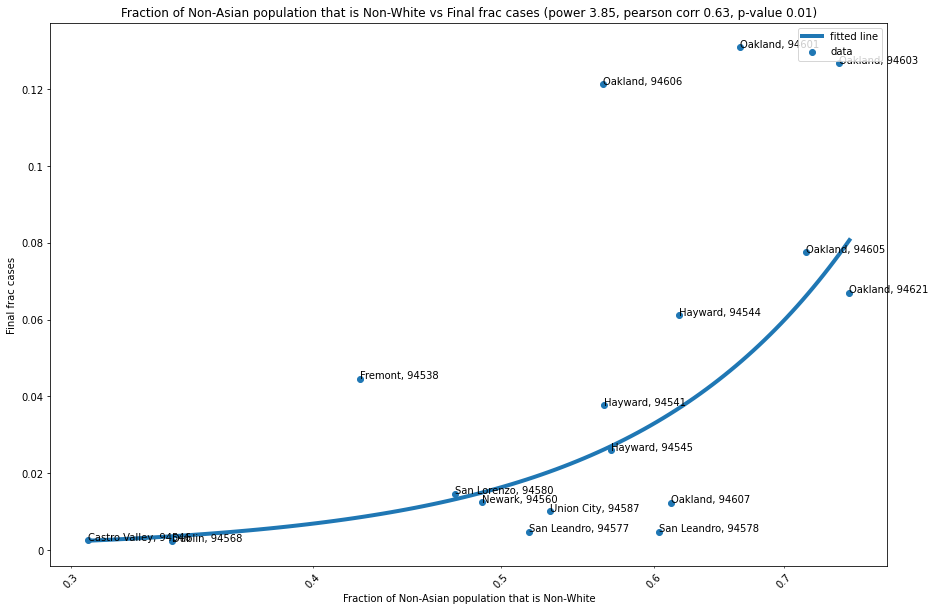

<Figure size 432x288 with 0 Axes>

In [466]:
save_fig_path = 'data/images/alameda'

fit_locations = locations_with_cases[
    (locations_with_cases['Cases'] >= 50)
    & (~locations_with_cases['Location'].isin(['94619', '94704', '94611', '94602']))]

for x_col in ['Fraction of Non-Asian population that is Non-White',]:
    for y_col in ['Frac Cases', 'R', 'Final cases', 'Final frac cases']:
        power_law_plot(fit_locations,
                       x_col, y_col,
                       y_log_scale=False,
                       save_fig_path=save_fig_path,
                      )

In [439]:
# Function to plot trend line
def animated_power_law_plot(df, x_col, y_col, x_log_scale=True, y_log_scale=True, save_fig_path=''):
    df = df[~df[x_col].isna()]
    dates_list = sorted(df.index.unique())
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_xlim(df[x_col].min() * 0.9, df[x_col].max() * 1.1)
    ax.set_ylim(df[y_col].min() * 1.0, df[y_col].max() * 1.0)
    if x_log_scale:
        ax.set_xscale('log')
    if y_log_scale:
        ax.set_yscale('log')
    formatter = ScalarFormatter()
    formatter = FormatStrFormatter('%.2g')
    ax.get_xaxis().set_minor_formatter(formatter)
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_minor_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    plt.xticks(rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    ax.legend()

    date_df = df[df.index==dates_list[0]]
    x = date_df[x_col].to_numpy()
    y = date_df[y_col].to_numpy()
    log_x = np.log(x)
    log_y = np.log(y)
    coef = np.polyfit(log_x, log_y, w=y, deg=1)   
    trend_line_x = np.linspace(np.min(x), np.max(x), 100)
    plt_line, = ax.plot(trend_line_x, np.exp(poly_line(np.log(trend_line_x), coef)), label='fitted line', linewidth=4)
    plt_points = ax.scatter(date_df[x_col],
               date_df[y_col],
               label='data')     
    all_locations = df['Location'].unique().tolist()
    location_to_label = {}
    for location in all_locations:
        location_df = df[df['Location'] == location]
        label = location_df['city'] + ', ' + location_df['Location']
        label = ax.annotate(label[0], xy=(0.001, 0.001))
        location_to_label[location] = label
        
    text_coords = zip(date_df[x_col].tolist(),
                      date_df[y_col].tolist())
    plt_title = ax.set_title('{}: (power {:.2f}, pearson corr {:.2f}, p-value {:.2f})'.format(
        dates_list[0].strftime('%b %d, %Y'), coef[0], *pearsonr(log_x, log_y)))   
    
    def init():
        #plt_points, plt_line = plot_date(dates_list[0], plt_points, plt_line)
        return (plt_line, plt_points, plt_title) + tuple(location_to_label.values())
    
    def animate(i):
        date_df = df[df.index==dates_list[i]]
        locations = date_df['Location'].to_numpy()
        x = date_df[x_col].to_numpy()
        y = date_df[y_col].to_numpy()
        log_x = np.log(x)
        log_y = np.log(y)
        coef = np.polyfit(log_x, log_y, w=y + 25, deg=1)   
        trend_line_x = np.linspace(np.min(x), np.max(x), 100)
        plt_line.set_data(trend_line_x, np.exp(poly_line(np.log(trend_line_x), coef)))
        plt_points.set_offsets(np.transpose(np.array([date_df[x_col].to_numpy(), date_df[y_col].to_numpy()])))   
        plt_title.set_text('{}: (power {:.2f}, pearson corr {:.2f}, p-value {:.2f})'.format(
            dates_list[i].strftime('%b %d, %Y'), coef[0], *pearsonr(log_x, log_y)))
        for label in location_to_label.values():
            label.set_position((0.001, 0.001))
            label.xy = (0.001, 0.001)            
        for j in range(locations.shape[0]):
            label = location_to_label[locations[j]]
            label.set_position((x[j], y[j]))
            label.xy = (x[j], y[j])
        return (plt_line, plt_points, plt_title) + tuple(location_to_label.values())

    ani = animation.FuncAnimation(
        fig, animate, frames=len(dates_list), init_func=init, interval=250, blit=True, save_count=len(dates_list))    
    HTML(ani.to_html5_video())
    if save_fig_path:
        ani.save('data/images/{} vs {}.mp4'.format(x_col, y_col))
        
    return ax

In [473]:
# Get the comprehensive dataframe with only positive cases and zip codes
MIN_CASES = 25
MIN_ZIP_CODES = 10

pos_zip_alameda_df = alameda_df[
    (alameda_df['Cases'] >= MIN_CASES)
    & (alameda_df['Location'].str.contains('9'))
]
num_zips_by_date = pos_zip_alameda_df.groupby(pos_zip_alameda_df.index).count()['Location']
min_date = num_zips_by_date[num_zips_by_date >= MIN_ZIP_CODES].index[0]

pos_zip_alameda_df = pos_zip_alameda_df[pos_zip_alameda_df.index >= min_date]
pos_zip_alameda_df = pos_zip_alameda_df.join(demographics_df, on='Location', how='left')
pos_zip_alameda_df = pos_zip_alameda_df.join(pop_df[['city', 'population', 'density']], on='Location', how='left')
pos_zip_alameda_df['Cases per capita'] = pos_zip_alameda_df['Cases'] / pos_zip_alameda_df['population']
pos_zip_alameda_df = pos_zip_alameda_df.join(alameda_income_df[['Indicator Value']],
                                                 on='Location', how='left')
pos_zip_alameda_df = pos_zip_alameda_df.rename(columns={'Indicator Value': 'Median Income'})

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

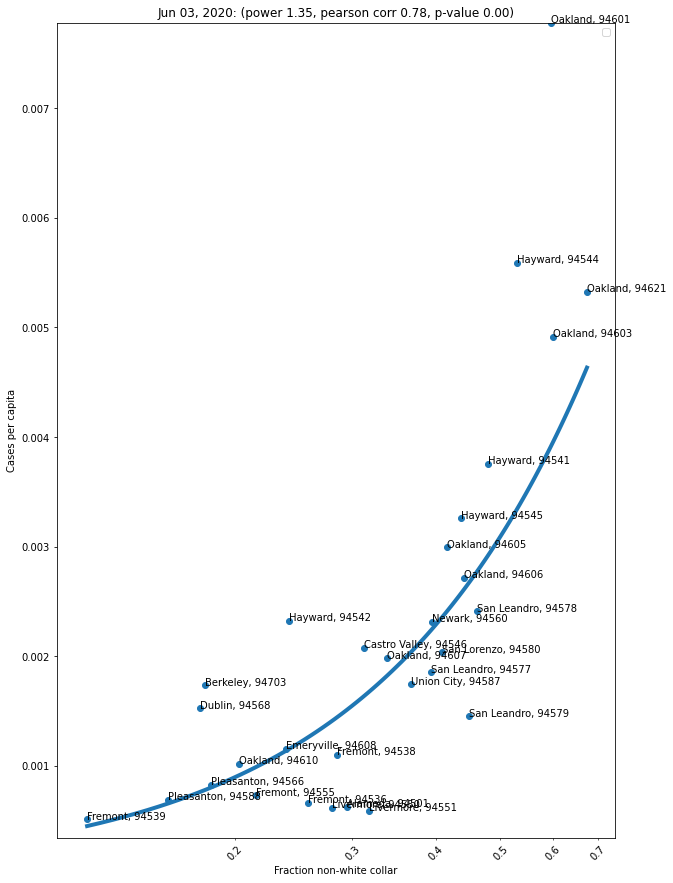

In [474]:
for x_col in [
#     'Fraction of population that is Black',
#     'Fraction of population that is Latino',
#     'Fraction of population that is Asian',
#     'Fraction of population that is White',
#    'Fraction of population that is Black or Other',
#    'Fraction of population that is Asian or White',
#    'Fraction of population that is Non-Asian and Non-White',
#    'Fraction of Non-Asian population that is Non-White',
    'Fraction non-white collar',
#     'Median Income',
]:
    for y_col in ['Cases per capita']:
        plt.clf()
        fit_locations = pos_zip_alameda_df[
            (pos_zip_alameda_df['Cases'] >= 25)
            & (~pos_zip_alameda_df['Location'].isin(['94619', '94704', '94611', '94602']))]
        animated_power_law_plot(fit_locations, x_col, y_col, y_log_scale=False, save_fig_path=True)

In [448]:
np.power(6, 0.6)

2.930156051583521